In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
import sys
sys.path.append('../.venv/lib/python3.7/site-packages/')

In [3]:
import numpy as np
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import reliability as rel
import calibration as cal
from sklearn.metrics import accuracy_score

In [4]:
plt.style.use("ggplot")
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

In [5]:
def plot_reliability(probs, classes, kernel, even_mass, num_points, fig, ax, q_label,
                     show_bars=False, show_counts=False, show_kernel=False, show_colormap=False):   
    curve = rel.ReliabilityFit(probs, classes, kernel, even_mass).get_curve(num_points)
    curve.plot(fig, ax, False, show_bars, show_counts, show_kernel, show_colormap)
    ece = curve.ece()
    ax.set_title(q_label+"\n"+f"(ECE={ece:.2f})", pad=15)
    ax.set_aspect('equal')
    
    return curve

def plot_unified_reliability(probs, classes, kernel, even_mass, num_points, show_bars=False, 
                             show_counts=False, show_kernel=False, show_colormap=False):    
    fig, ax = plt.subplots(1, 3, figsize=(20, 5))
    titles = [
        'Class 0',
        'Class 1',
        'Class 2'
    ]
    for i in range(3):        
        curve = plot_reliability(probs[:, i], 
                                 np.array(classes==i, dtype=int), 
                                 kernel, 
                                 even_mass, 
                                 num_points, 
                                 fig,
                                 ax[i], 
                                 titles[i],
                                 show_bars, 
                                 show_counts, 
                                 show_kernel,
                                 show_colormap)
        
    plt.show()

def plot_calibration_grid(probs_train, classes_train, cal_method, classes_val):
    accuracy = accuracy_score(classes_train, np.argmax(probs_train, axis=1))
    print('Original Training - Accuracy = {:.2f}'.format(accuracy))
    plot_unified_reliability(probs_train, 
                             classes_train, 
                             rel.DeltaKernel(), 
                             even_mass=False, 
                             num_points=10,                          
                             show_bars=True, 
                             show_counts=True, 
                             show_kernel=False, 
                             show_colormap=False)
    
    print('Calibrated Training (unormalized)')
    cal_method.fit(probs_train, classes_train)
    cal_probs = cal_method.transform(probs_train, normalize=False)
    plot_unified_reliability(cal_probs, 
                             classes_train, 
                             rel.DeltaKernel(), 
                             even_mass=False, 
                             num_points=10,                          
                             show_bars=True, 
                             show_counts=True, 
                             show_kernel=False, 
                             show_colormap=False)
    
    cal_probs = cal_method.transform(probs_train, normalize=True)
    accuracy = accuracy_score(classes_train, np.argmax(cal_probs, axis=1))
    print('Calibrated Training (normalized) - Accuracy = {:.2f}'.format(accuracy))    
    plot_unified_reliability(cal_probs, 
                             classes_train, 
                             rel.DeltaKernel(), 
                             even_mass=False, 
                             num_points=10,                          
                             show_bars=True, 
                             show_counts=True, 
                             show_kernel=False, 
                             show_colormap=False)
    
    accuracy = accuracy_score(classes_val, np.argmax(probs_val, axis=1))
    print('Original Val - Accuracy = {:.2f}'.format(accuracy))
    plot_unified_reliability(probs_val, 
                             classes_val, 
                             rel.DeltaKernel(), 
                             even_mass=False, 
                             num_points=10,                          
                             show_bars=True, 
                             show_counts=True, 
                             show_kernel=False, 
                             show_colormap=False)

    print('Calibrated Val (unormalized)')
    cal_probs = cal_method.transform(probs_val, normalize=False)
    plot_unified_reliability(cal_probs, 
                             classes_val, 
                             rel.DeltaKernel(), 
                             even_mass=False, 
                             num_points=10,                          
                             show_bars=True, 
                             show_counts=True, 
                             show_kernel=False, 
                             show_colormap=False)
    
    cal_probs = cal_method.transform(probs_val, normalize=True)
    accuracy = accuracy_score(classes_val, np.argmax(cal_probs, axis=1))
    print('Calibrated Val (normalized) - Accuracy = {:.2f}'.format(accuracy))
    plot_unified_reliability(cal_probs, 
                             classes_val, 
                             rel.DeltaKernel(), 
                             even_mass=False, 
                             num_points=10,                          
                             show_bars=True, 
                             show_counts=True, 
                             show_kernel=False, 
                             show_colormap=False)

# Data

In [22]:
# Generate a random classification problem
np.random.seed(42)
X, y = datasets.make_classification(n_samples=6000, n_features=20, n_informative=6, n_redundant=2, n_classes=3)

In [23]:
train_samples = 4000  # Samples used for training the model
X_train = X[:train_samples]
X_test = X[train_samples:]
y_train = y[:train_samples]
y_test = y[train_samples:]

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
prob_pos = rfc.predict_proba(X_test)

probs_train = prob_pos[:1000, :] # Used to calibrate the curves
classes_train = y_test[:1000]
probs_val = prob_pos[1000:, :] # Used to test the calibration
classes_val = y_test[1000:]

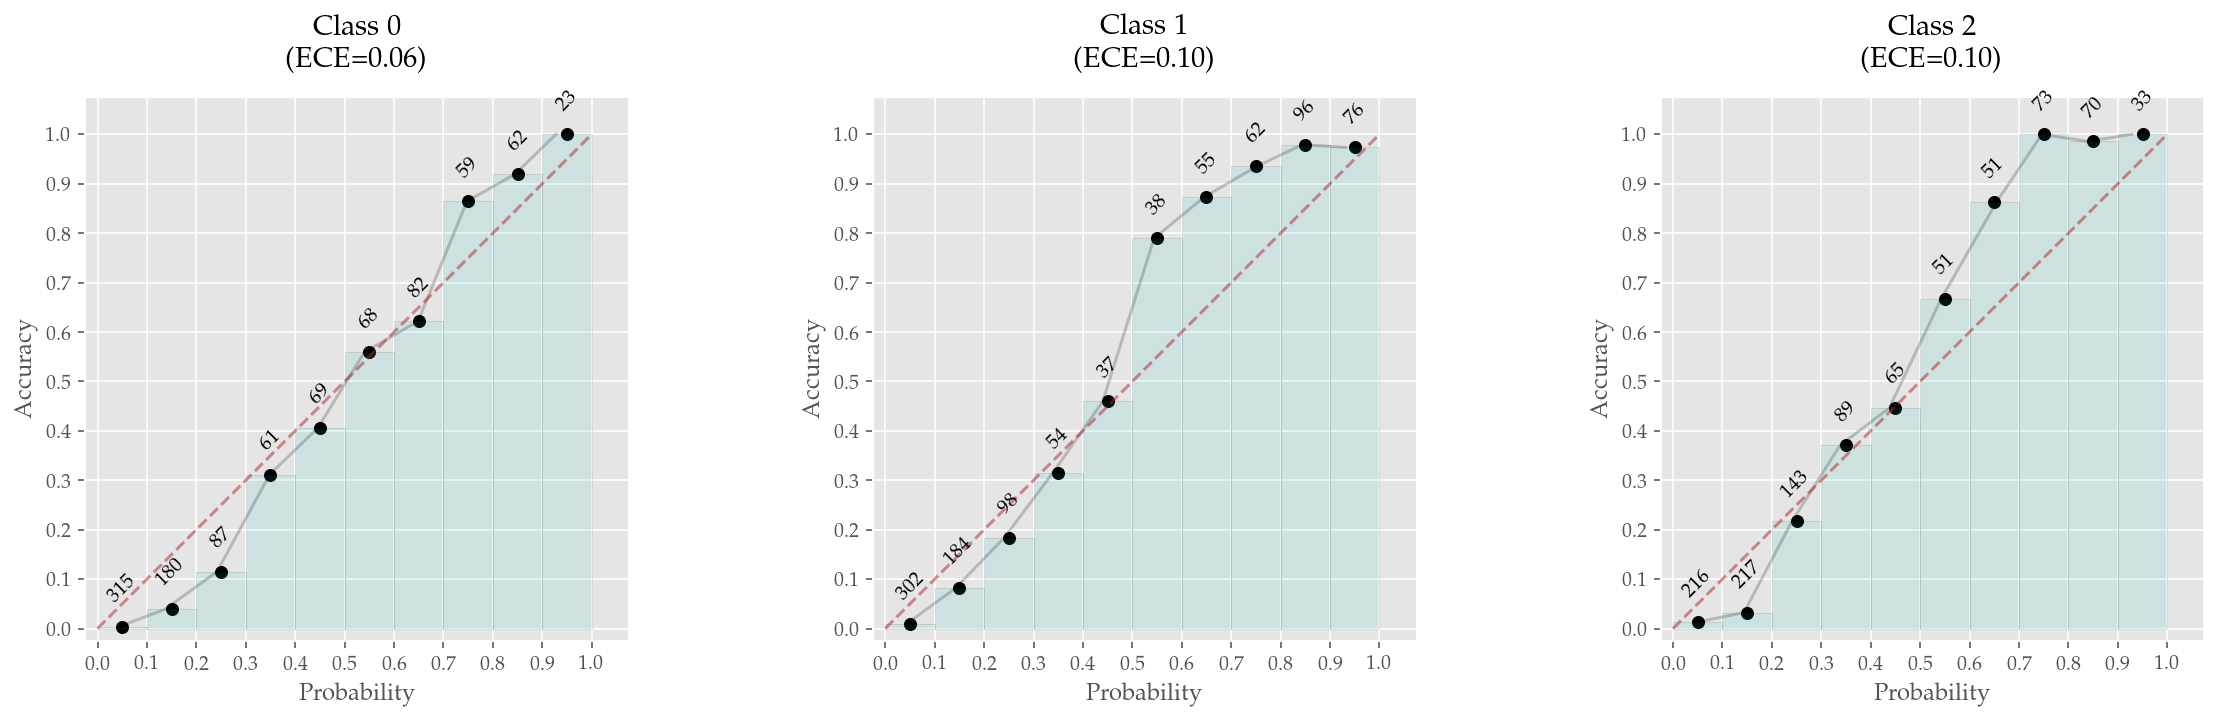

In [24]:
plot_unified_reliability(probs_train, 
                         classes_train, 
                         rel.DeltaKernel(), 
                         even_mass=False, 
                         num_points=10,                          
                         show_bars=True, 
                         show_counts=True, 
                         show_kernel=False, 
                         show_colormap=False)

# Binning

Original Training - Accuracy = 0.81


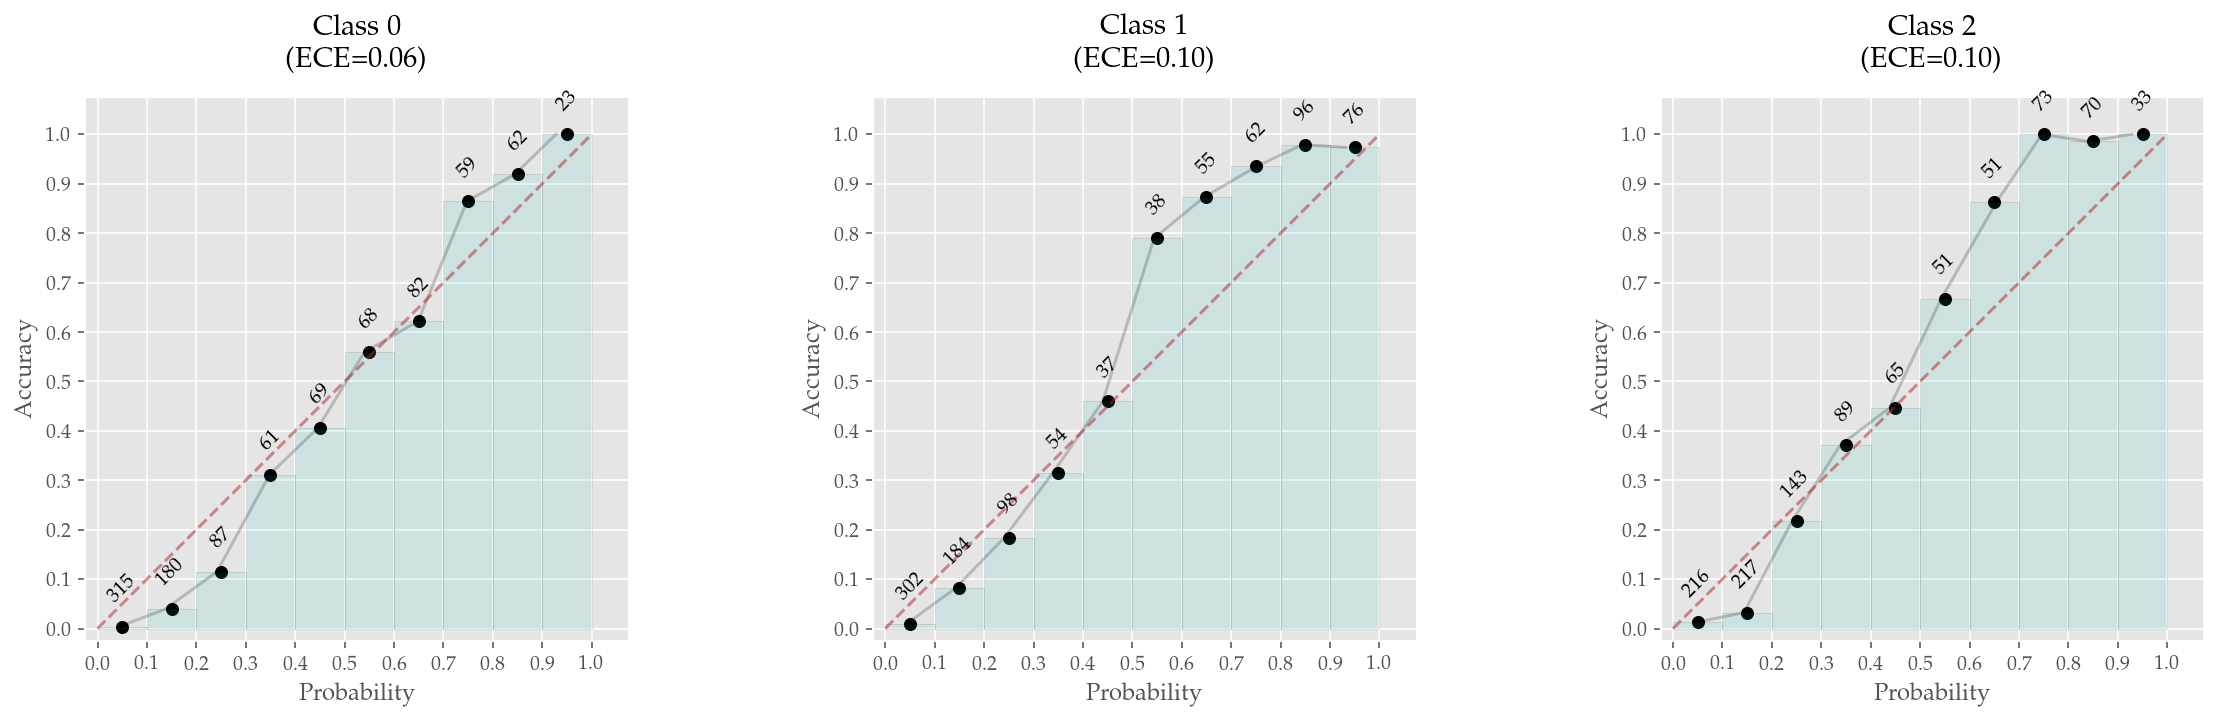

Calibrated Training (unormalized)


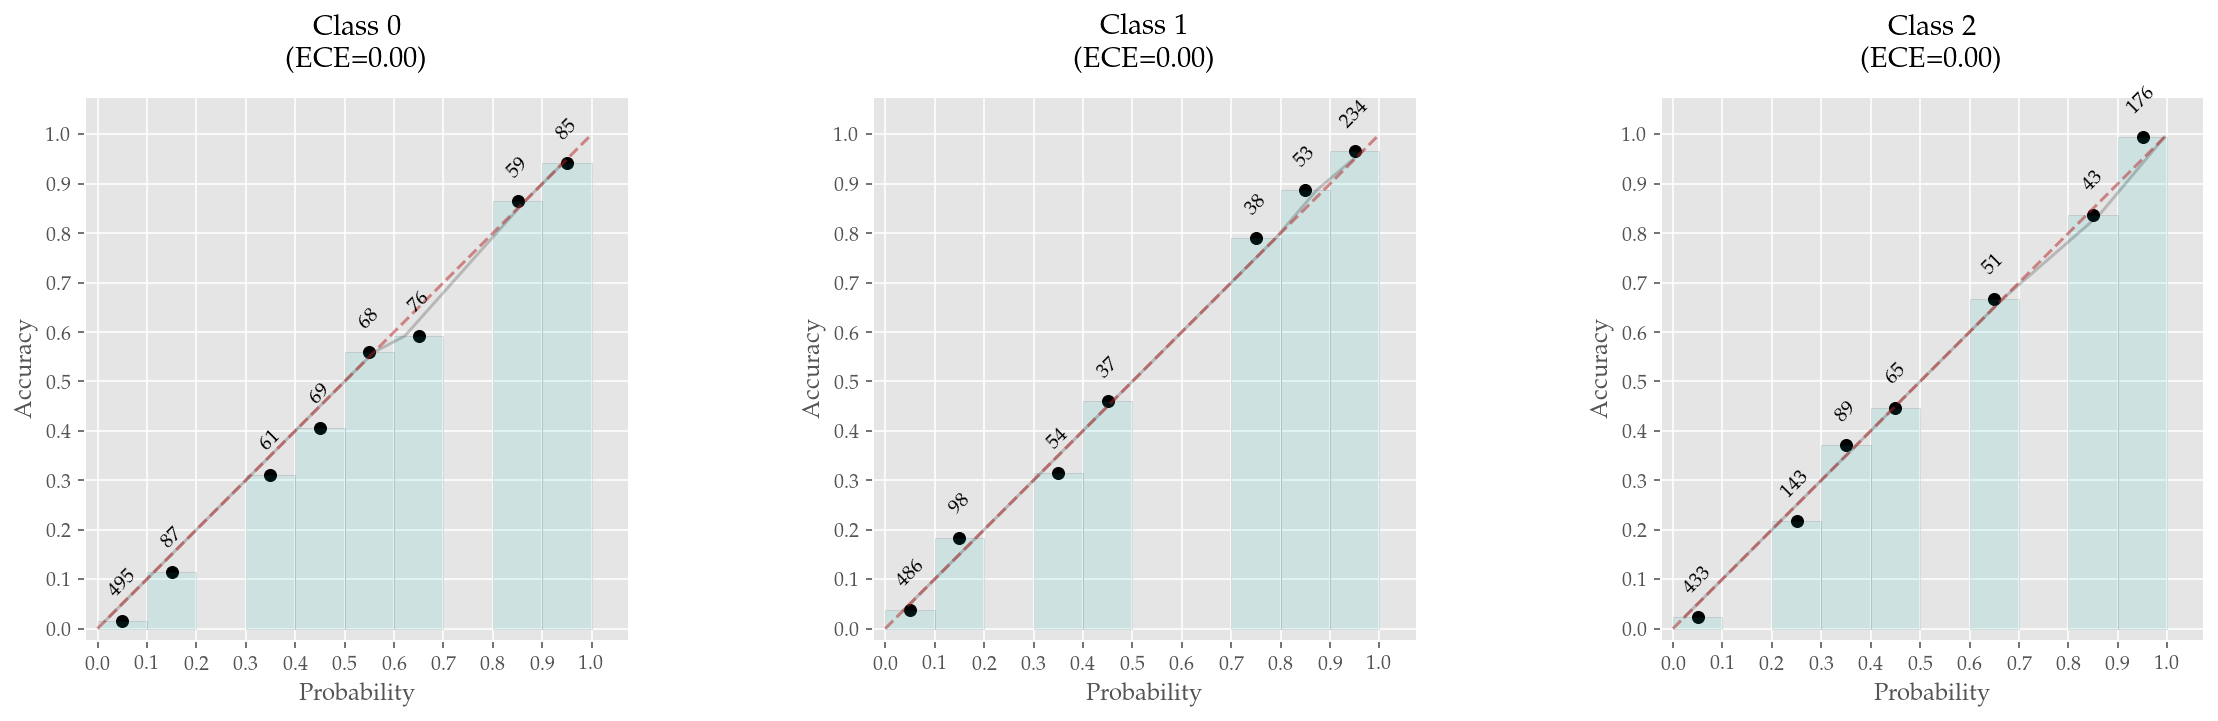

Calibrated Training (normalized) - Accuracy = 0.82


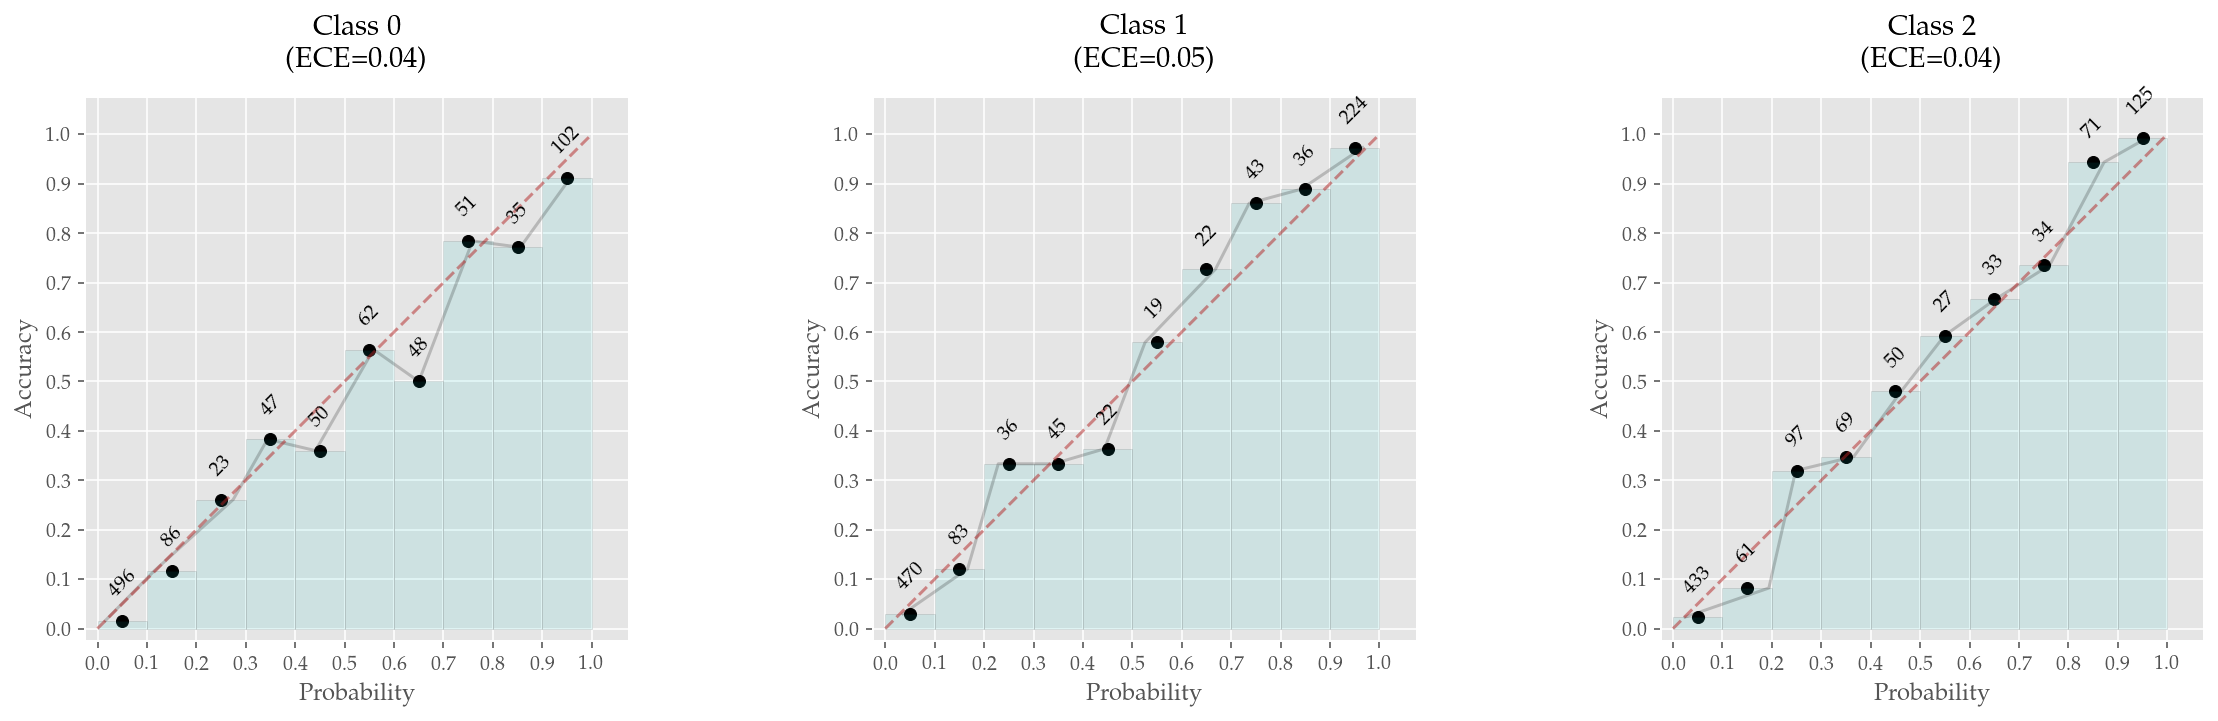

Original Val - Accuracy = 0.85


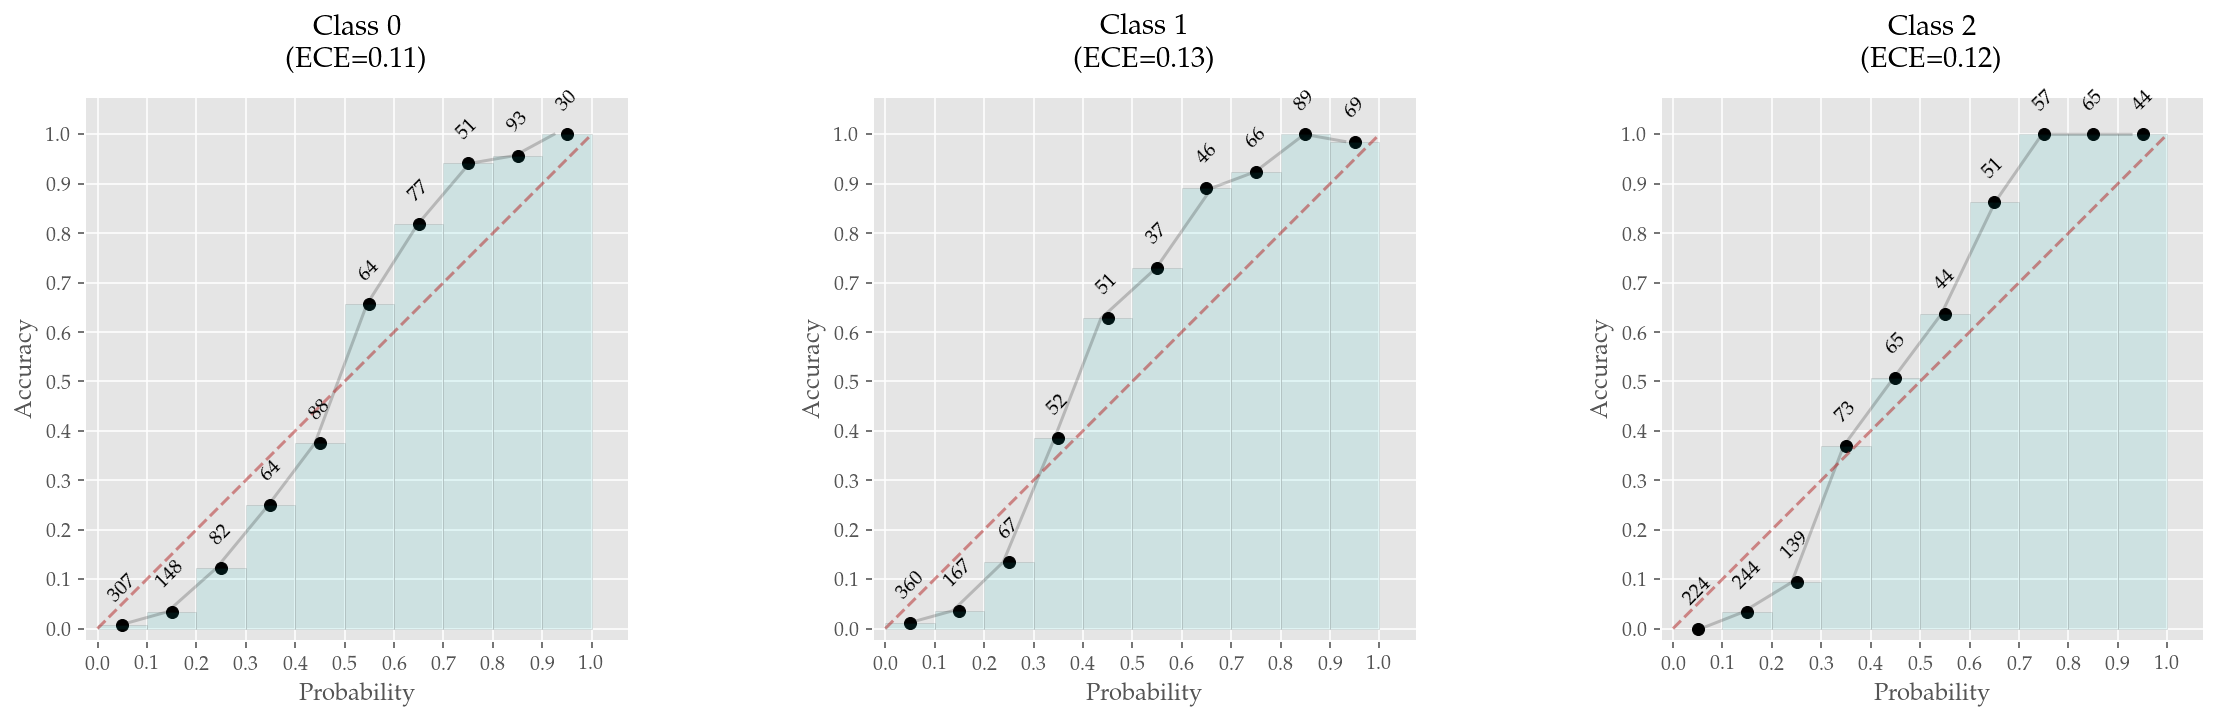

Calibrated Val (unormalized)


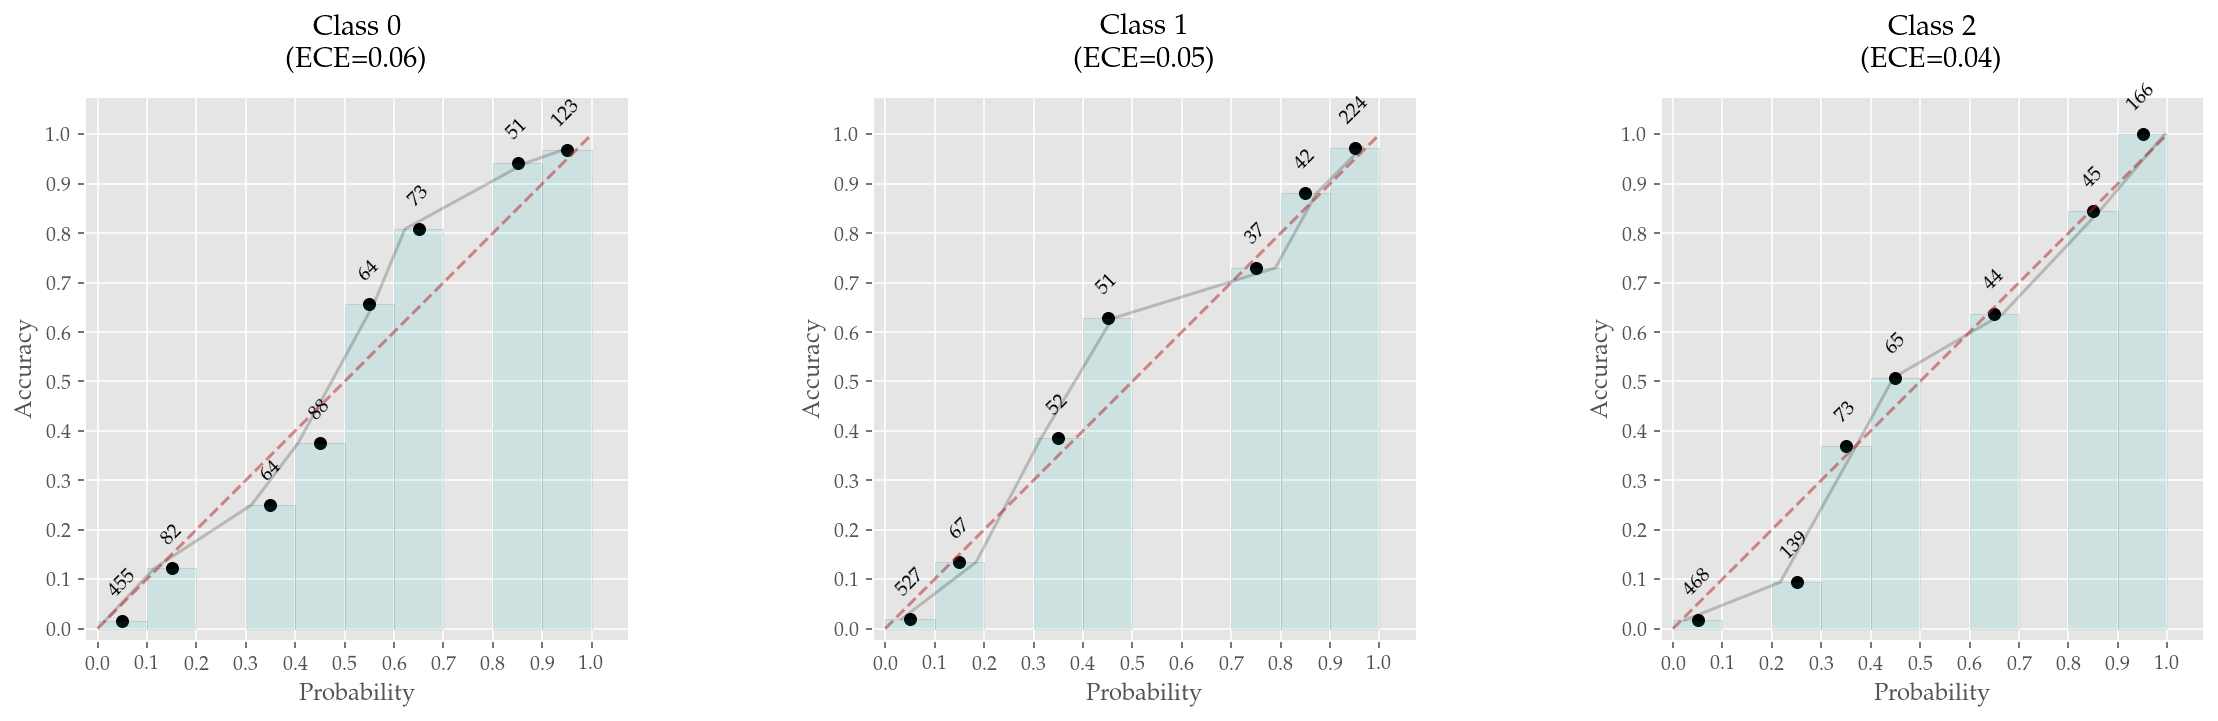

Calibrated Val (normalized) - Accuracy = 0.85


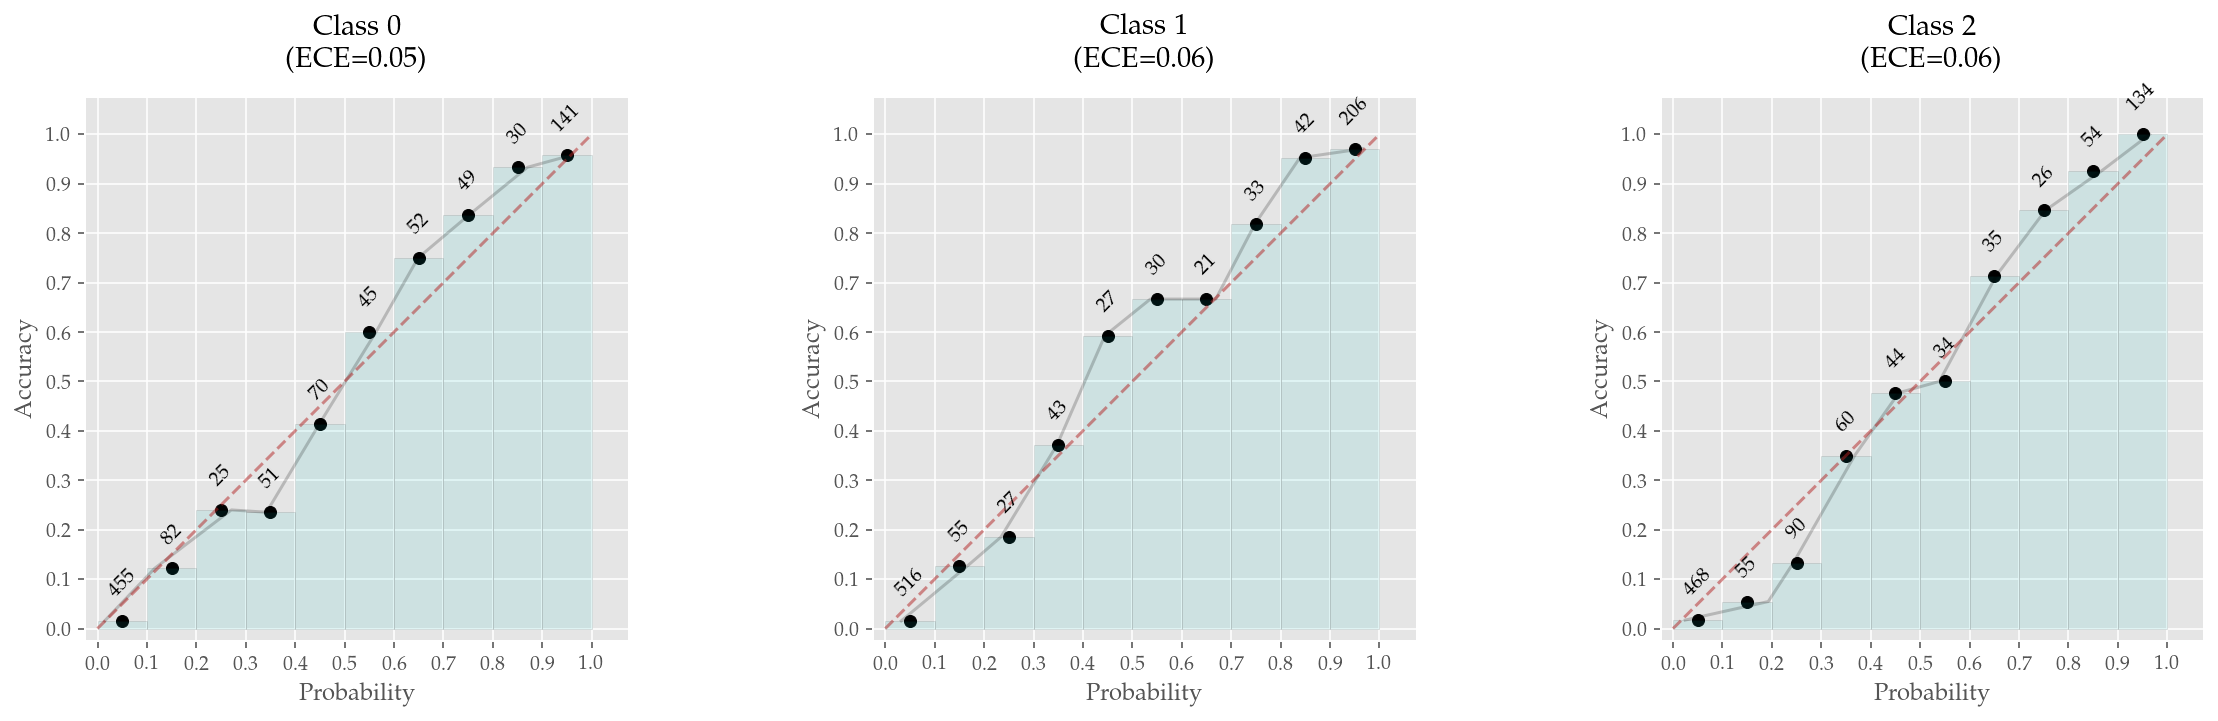

In [25]:
binning = cal.BinningCalibration(num_points=10, even_mass=False)
plot_calibration_grid(probs_train, classes_train, binning, classes_val)

# Isotonic

Original Training - Accuracy = 0.81


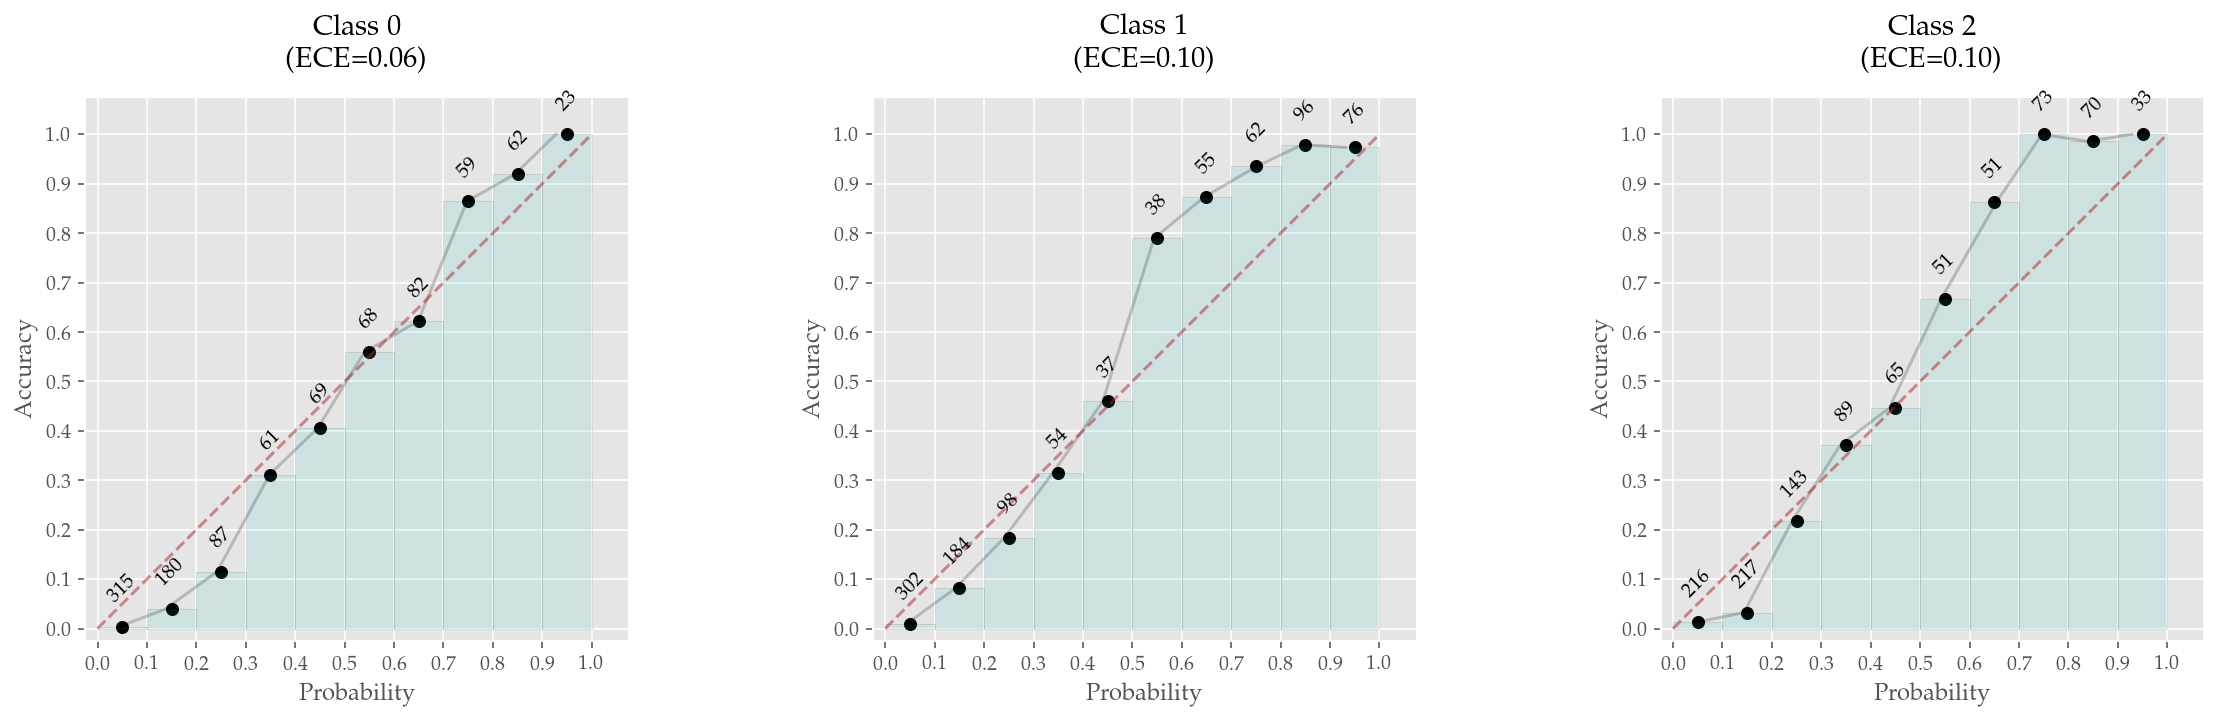

Calibrated Training (unormalized)


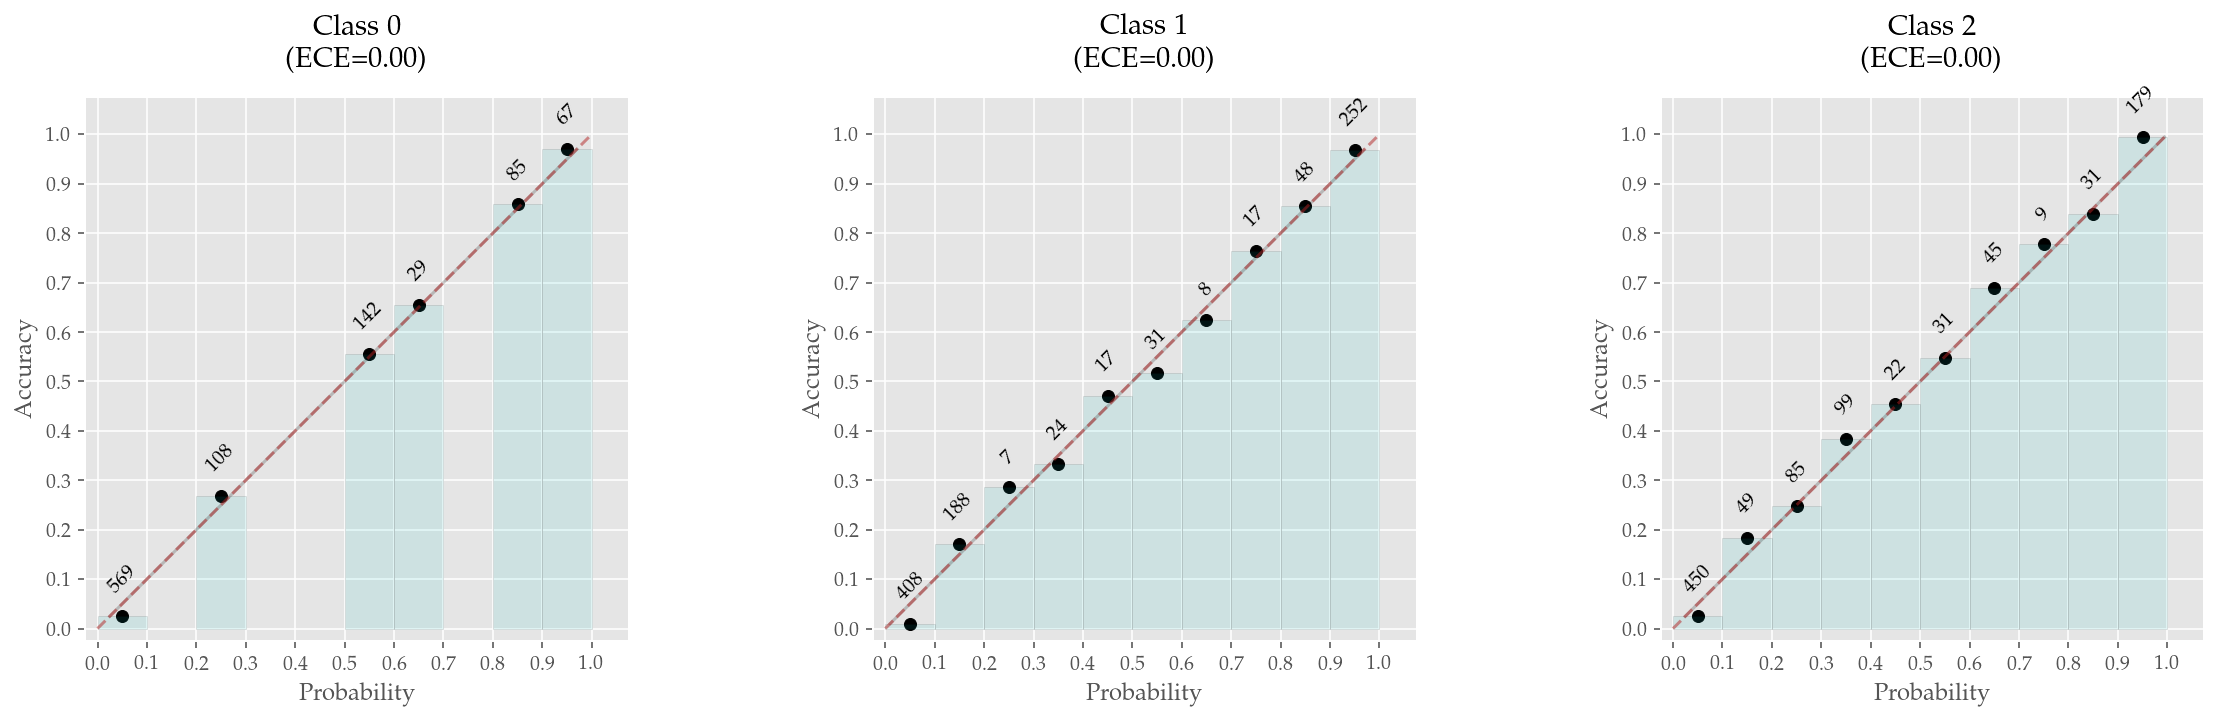

Calibrated Training (normalized) - Accuracy = 0.83


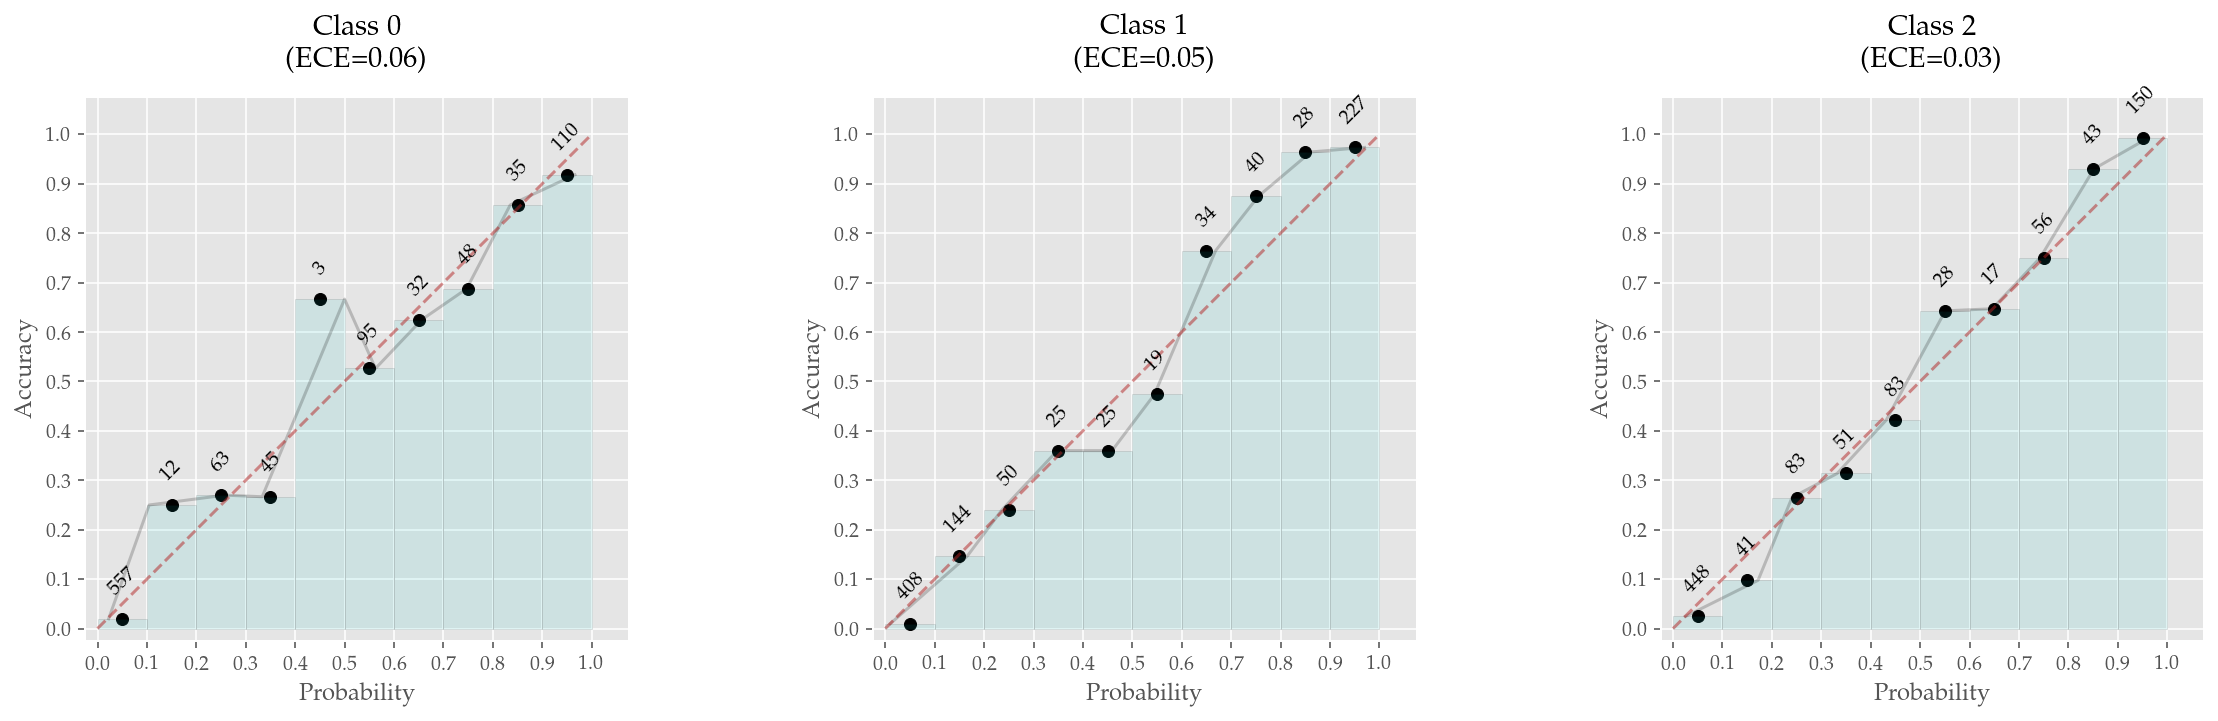

Original Val - Accuracy = 0.85


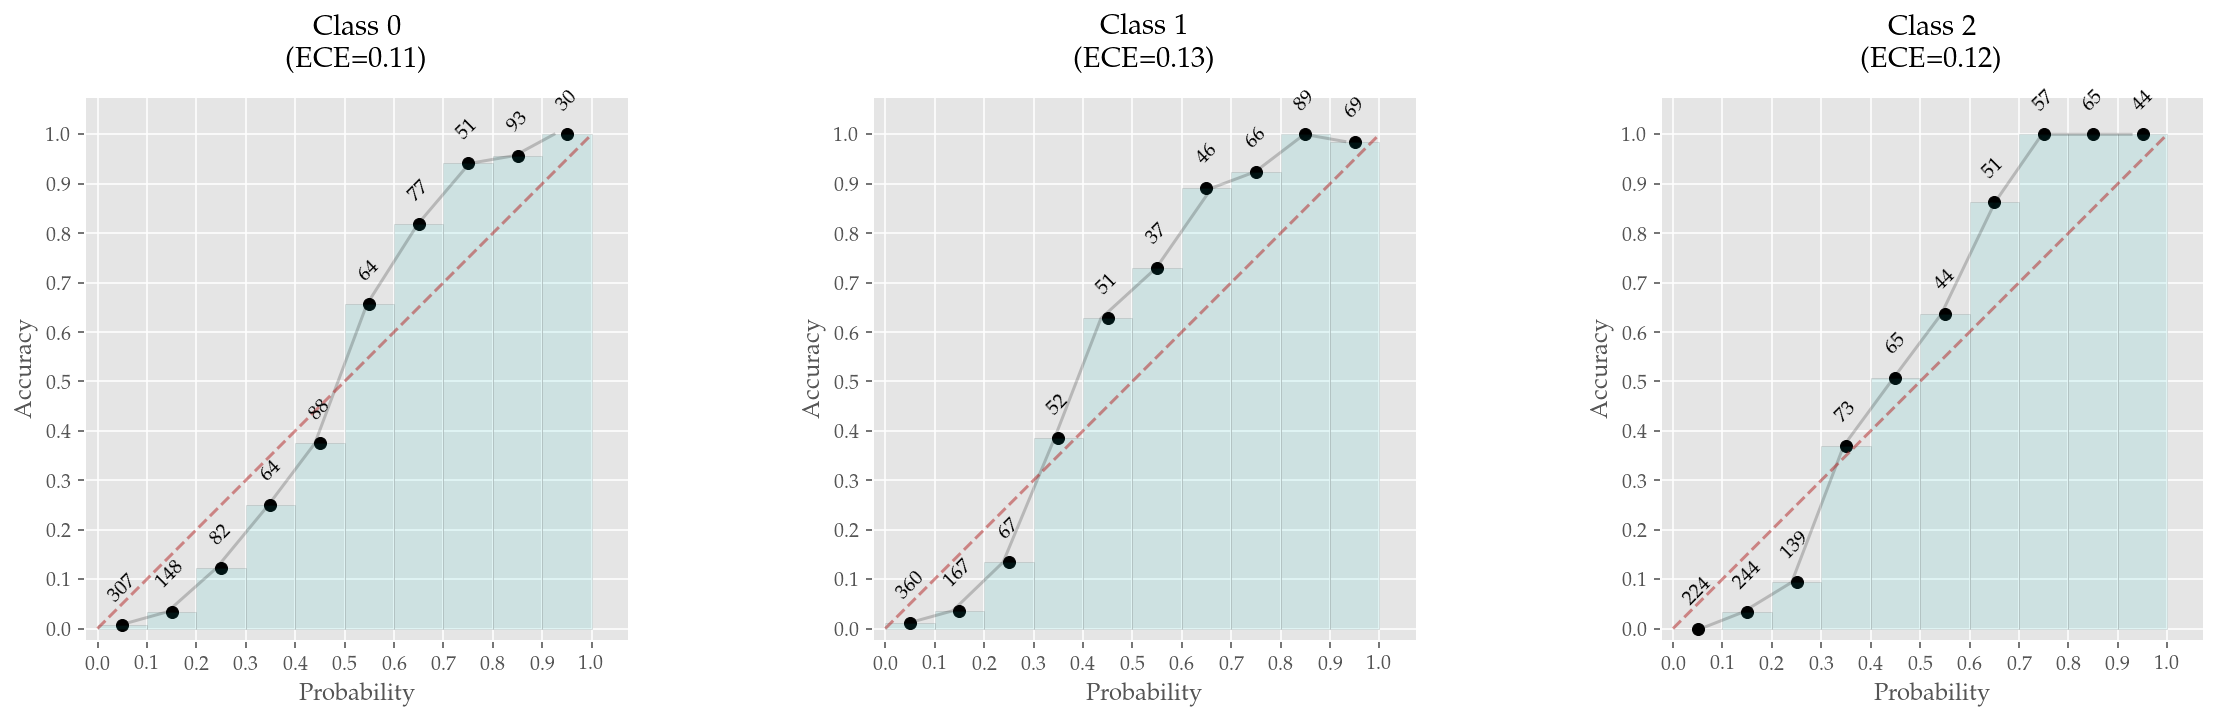

Calibrated Val (unormalized)


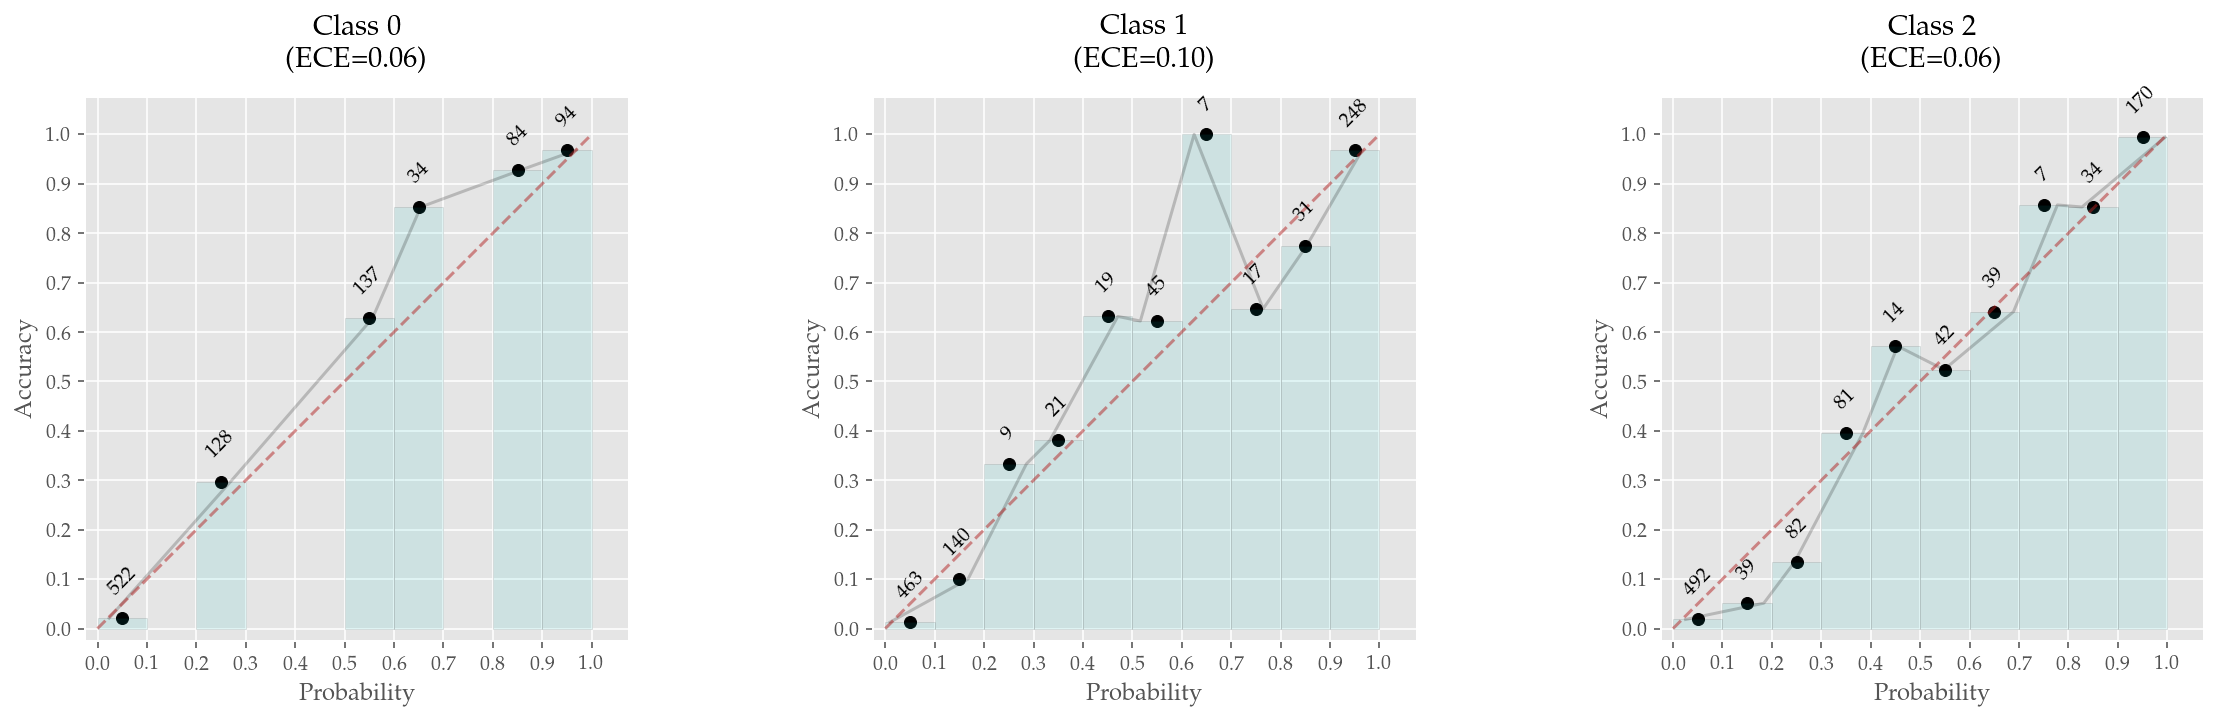

Calibrated Val (normalized) - Accuracy = 0.85


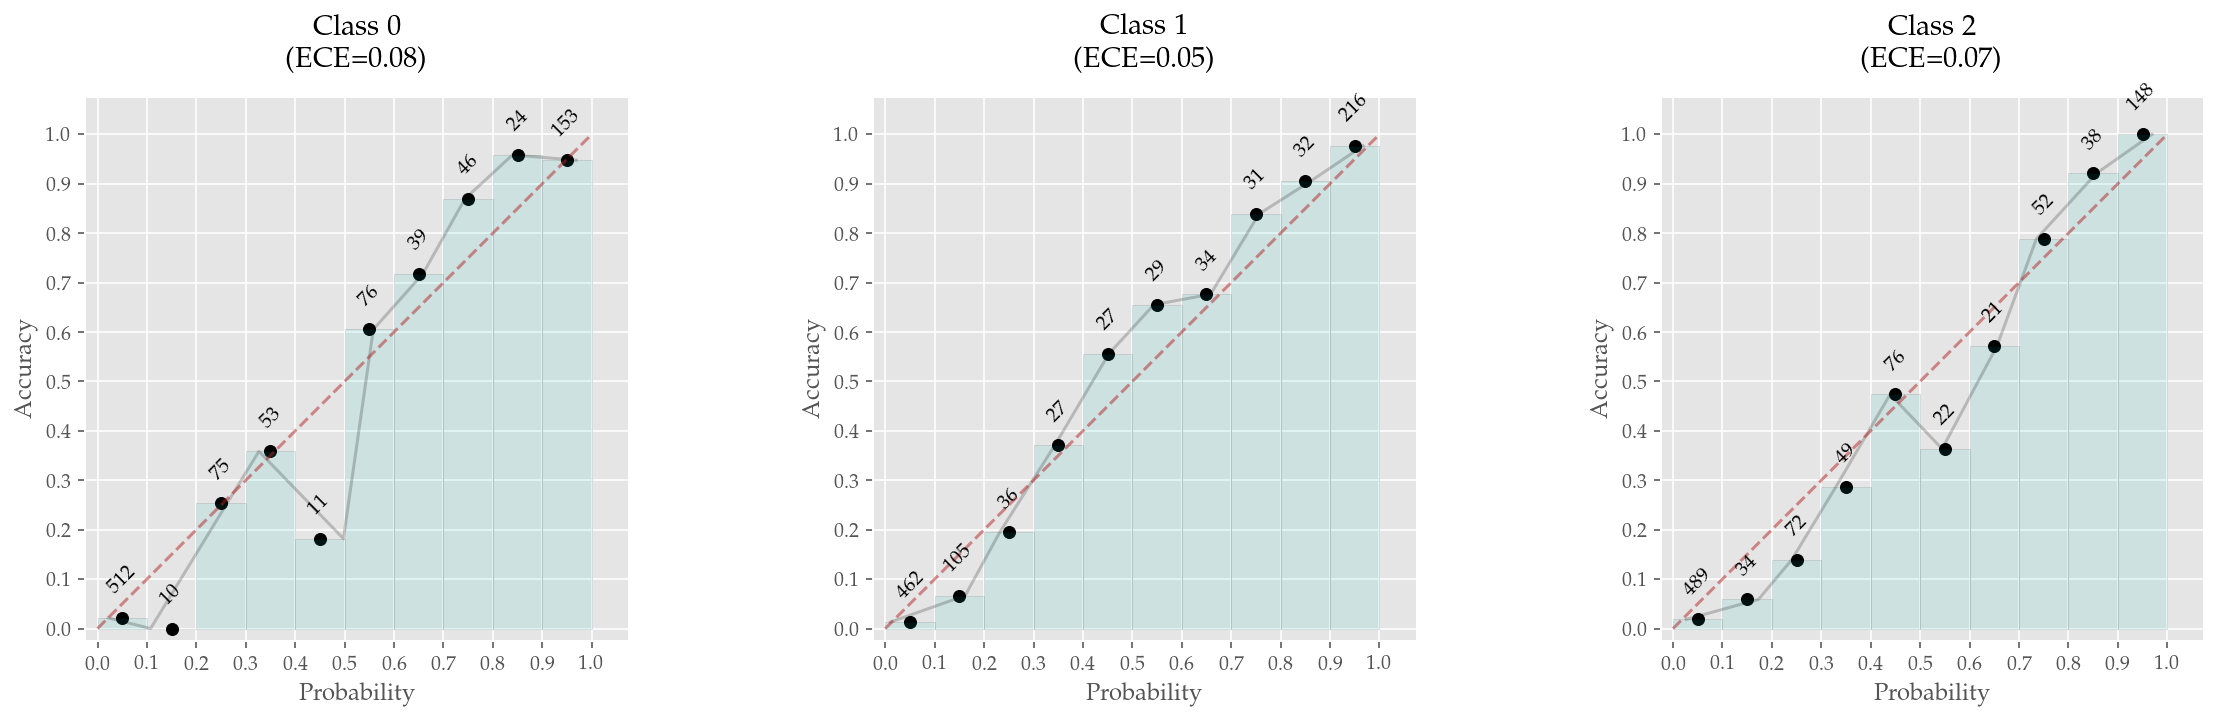

In [26]:
isotonic = cal.IsotonicCalibration()
plot_calibration_grid(probs_train, classes_train, isotonic, classes_val)

# Platt

Original Training - Accuracy = 0.81


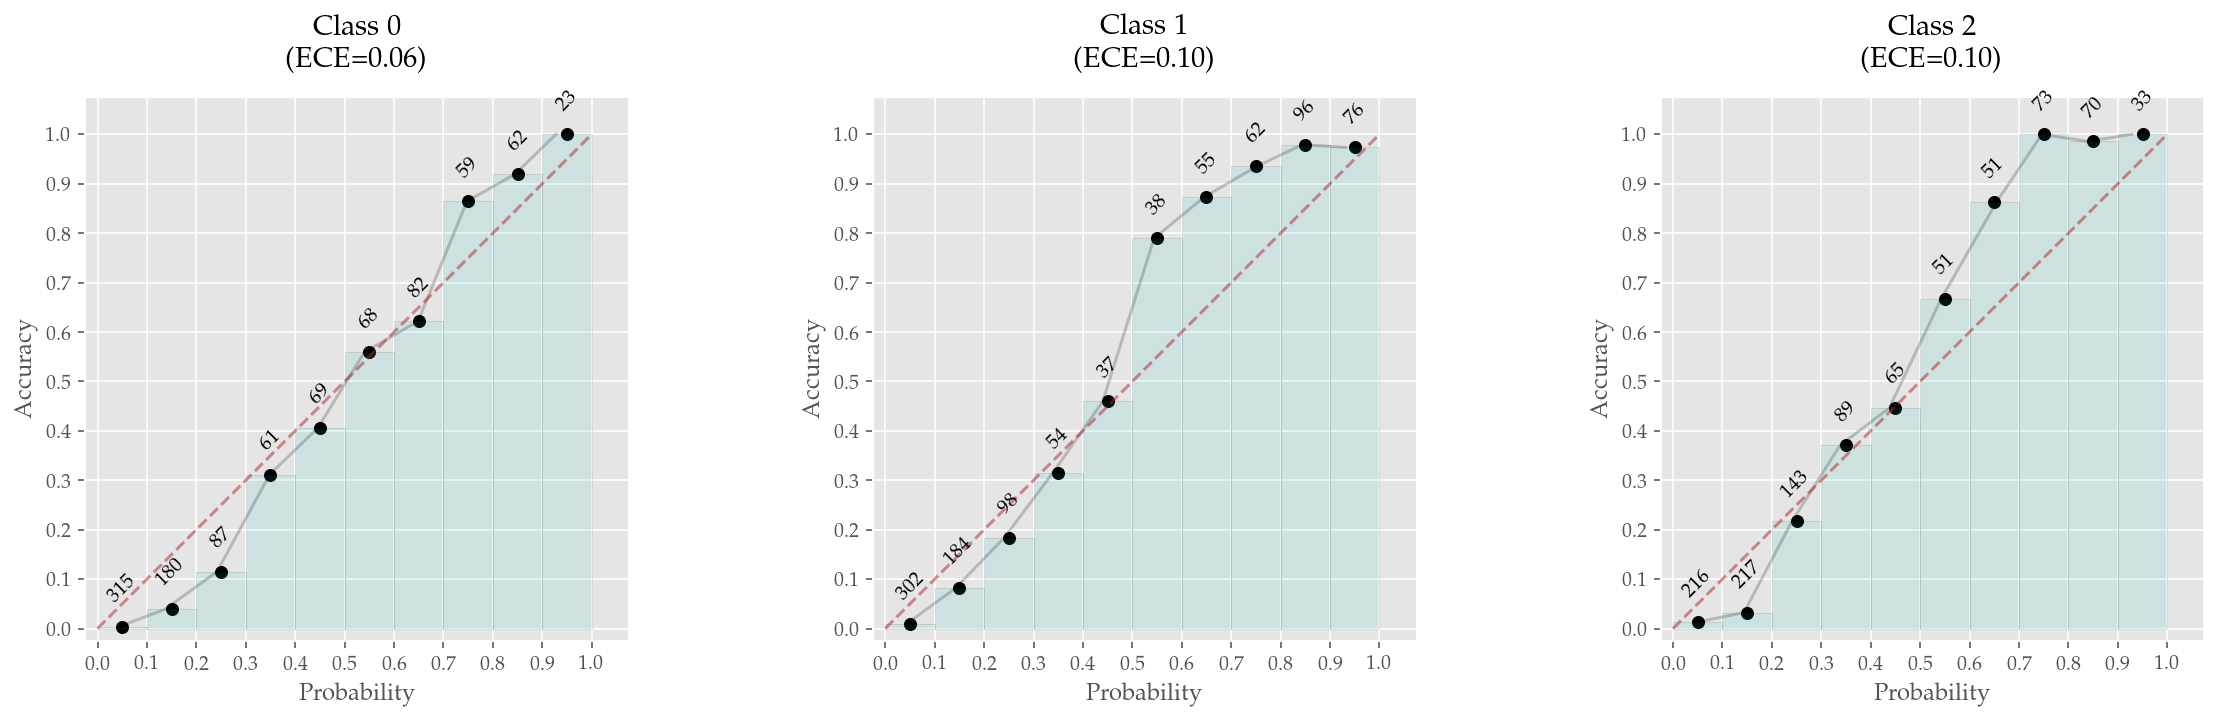

Calibrated Training (unormalized)


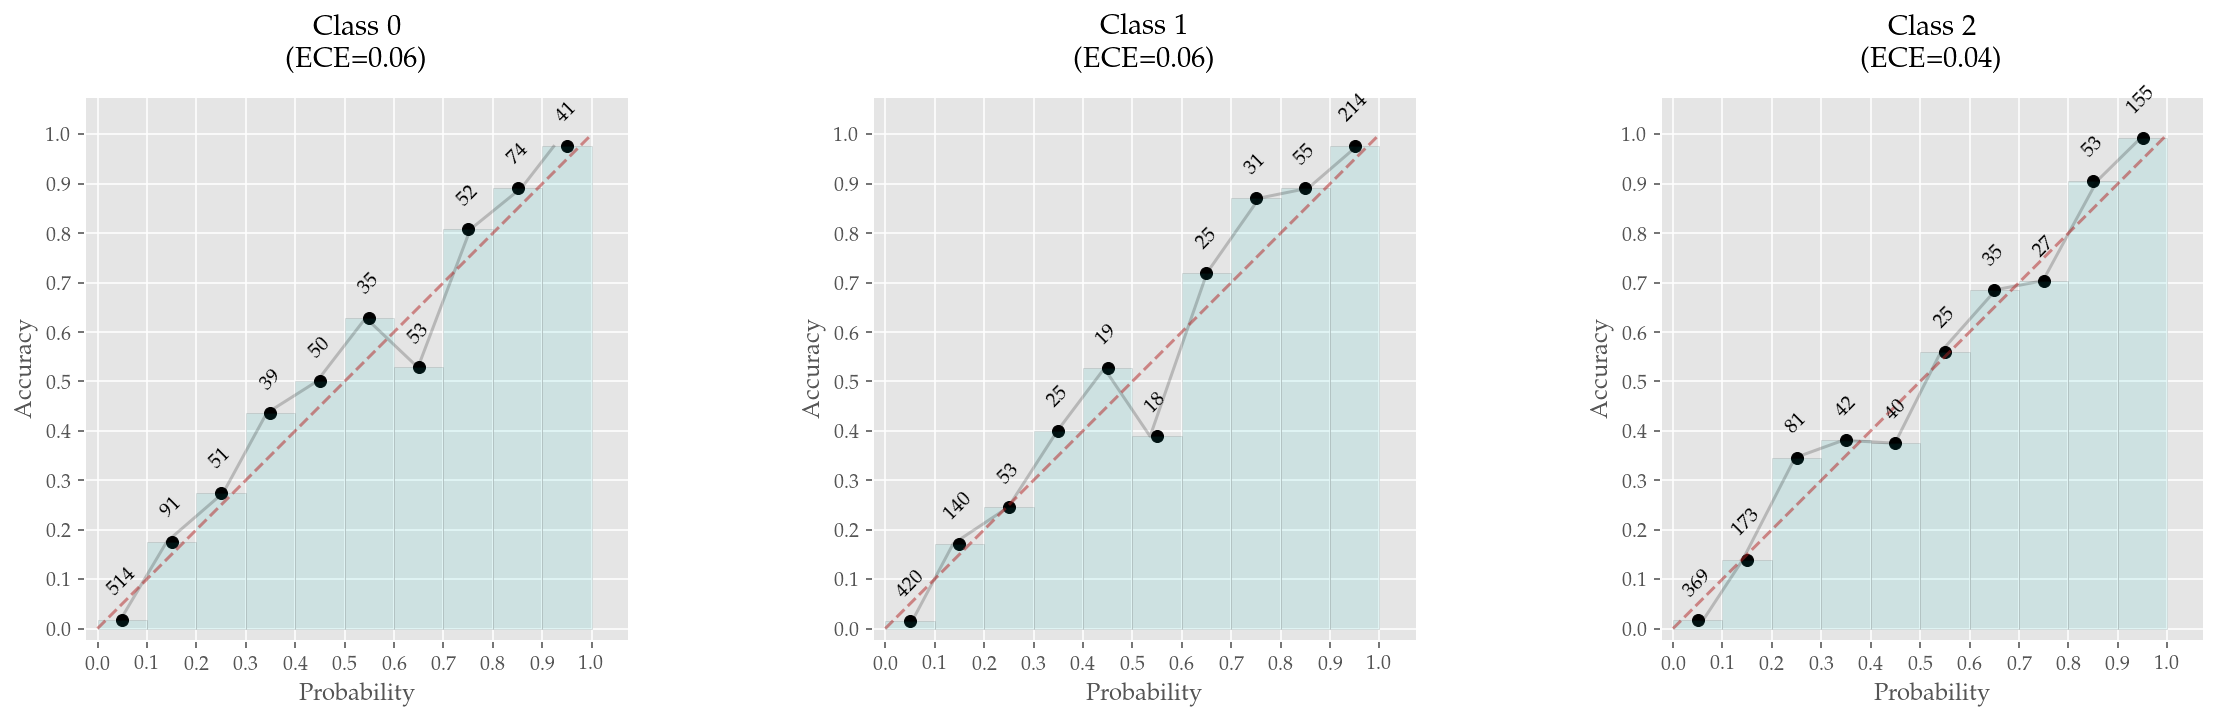

Calibrated Training (normalized) - Accuracy = 0.82


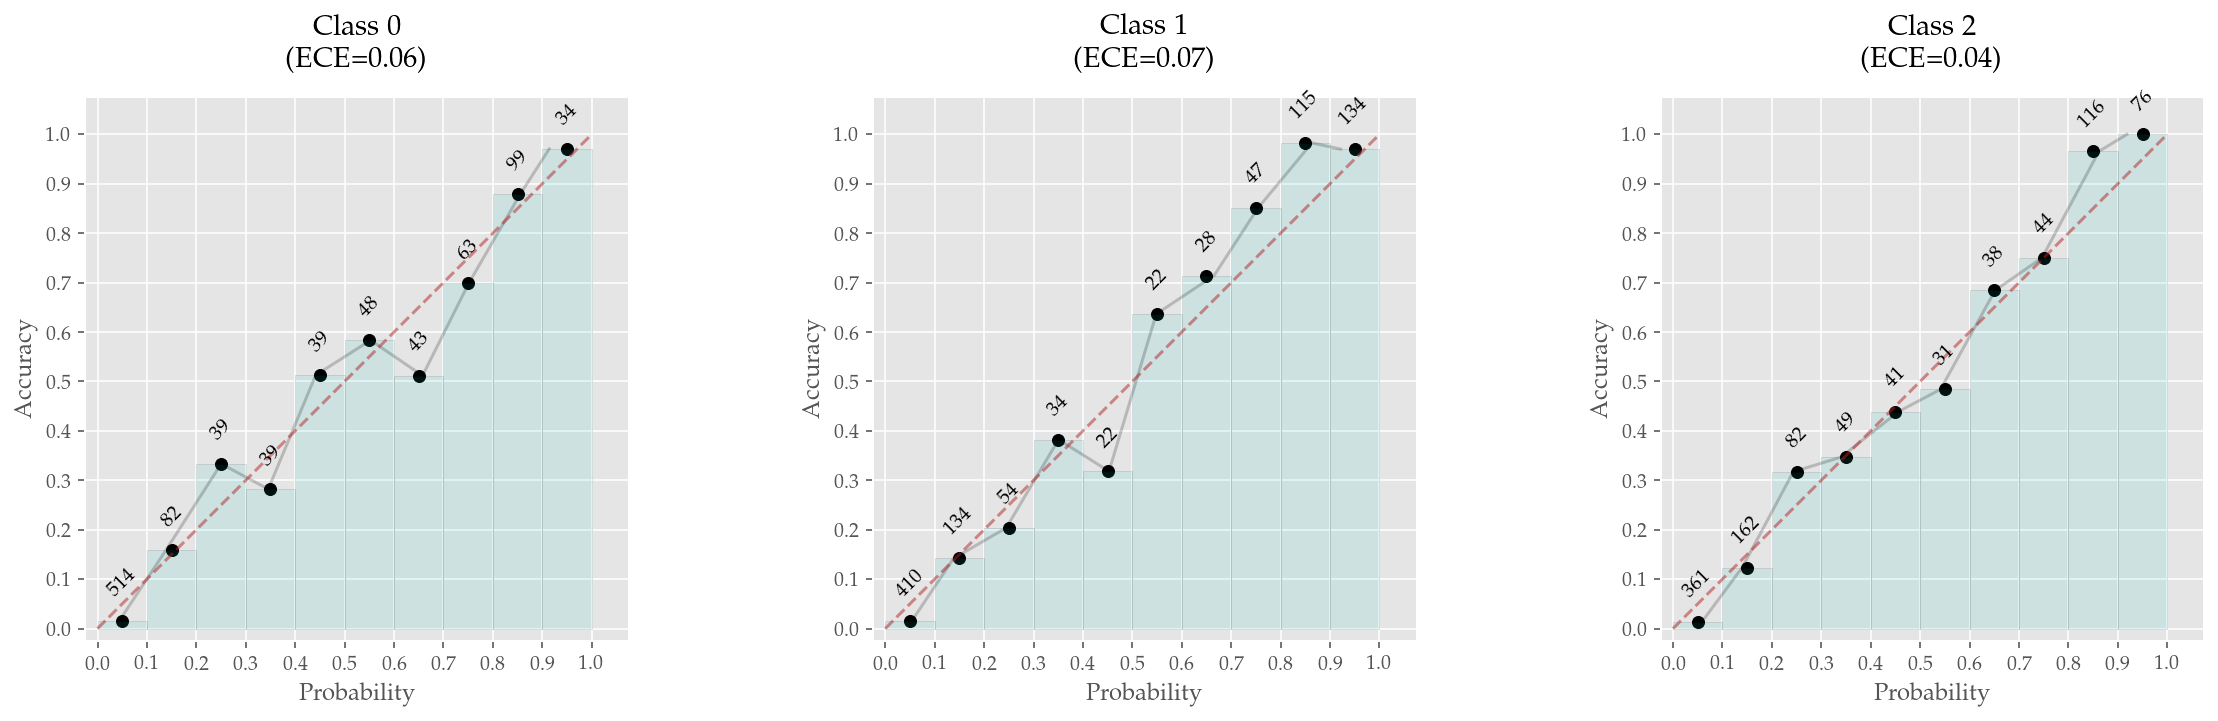

Original Val - Accuracy = 0.85


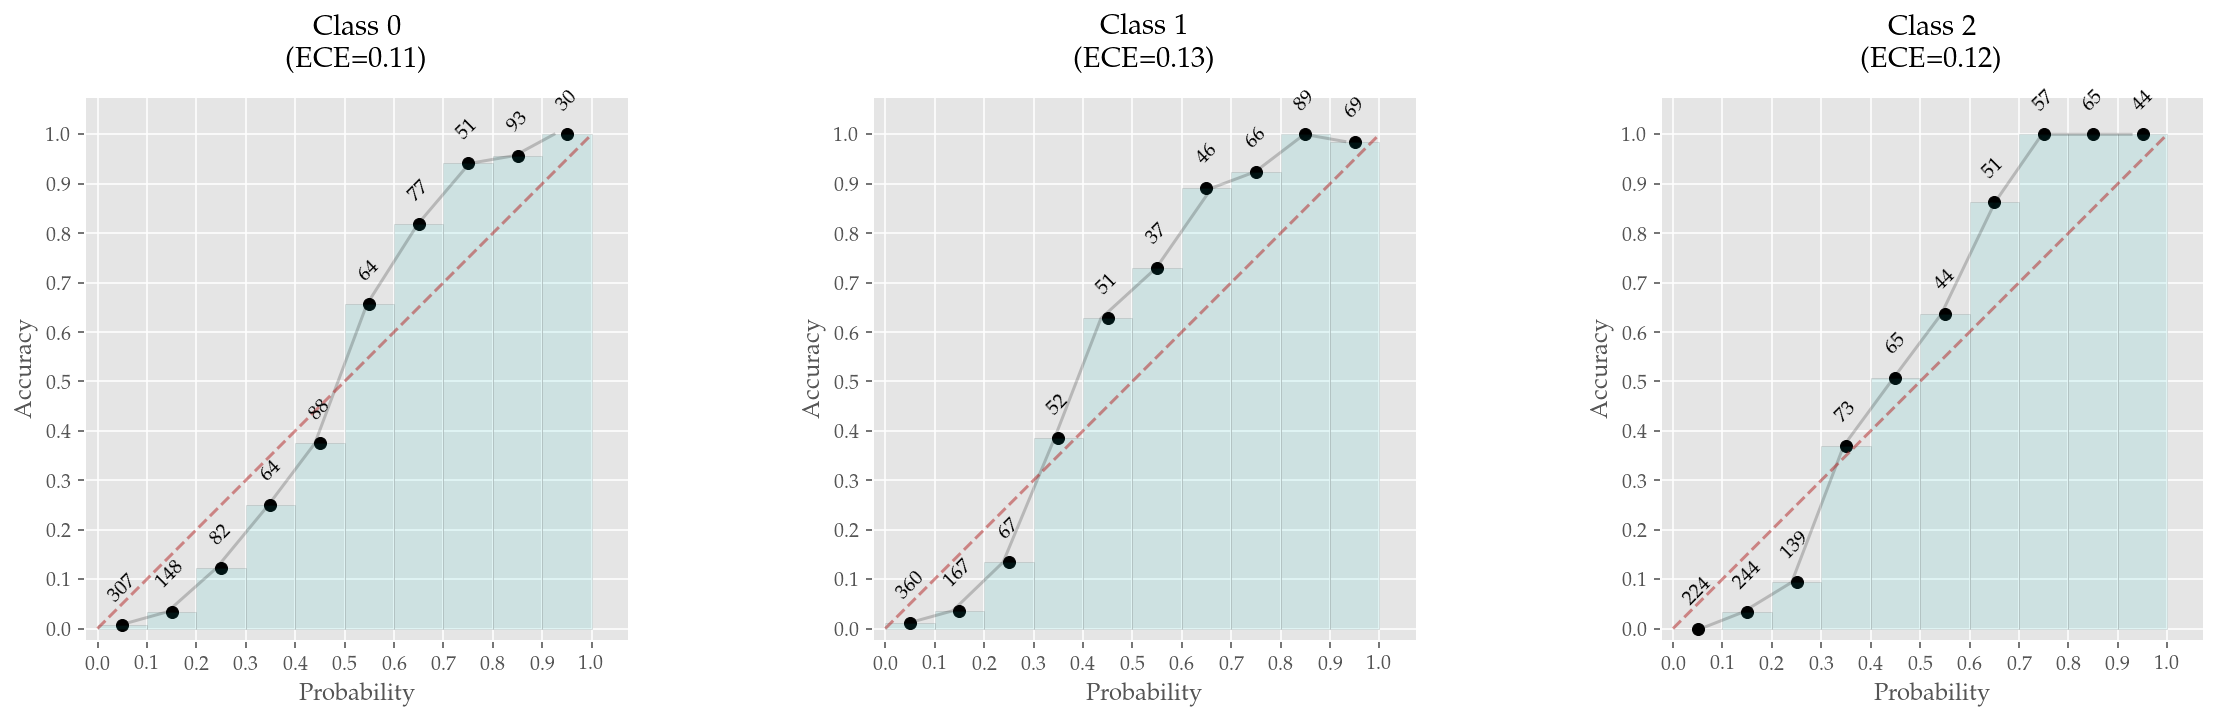

Calibrated Val (unormalized)


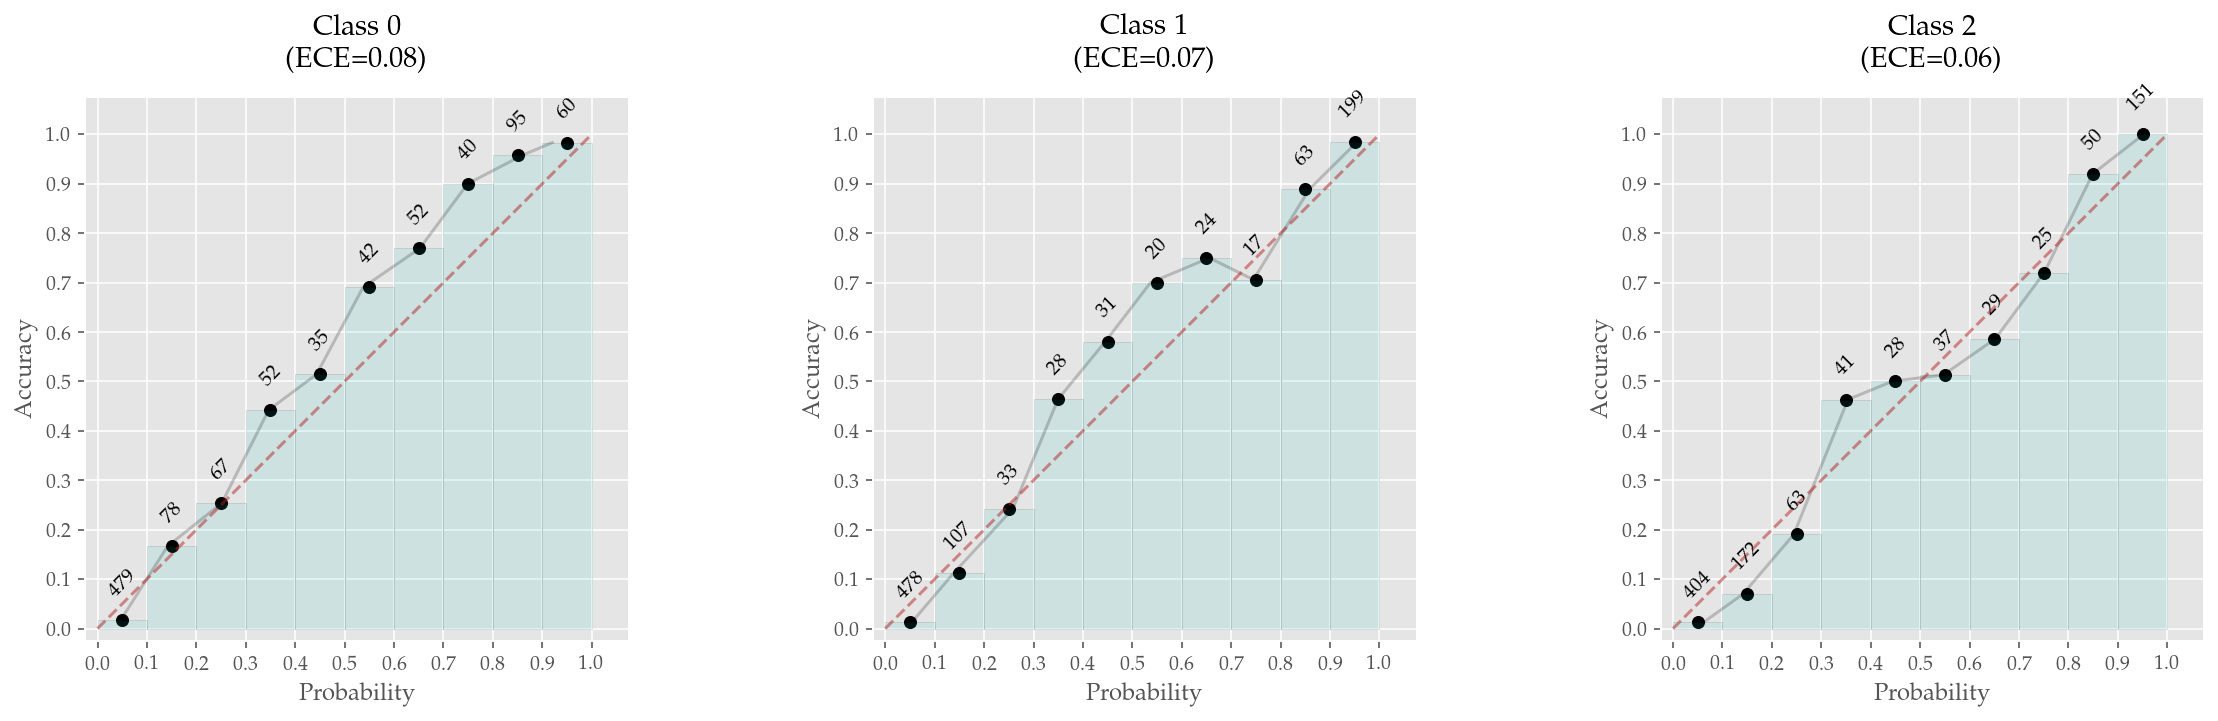

Calibrated Val (normalized) - Accuracy = 0.85


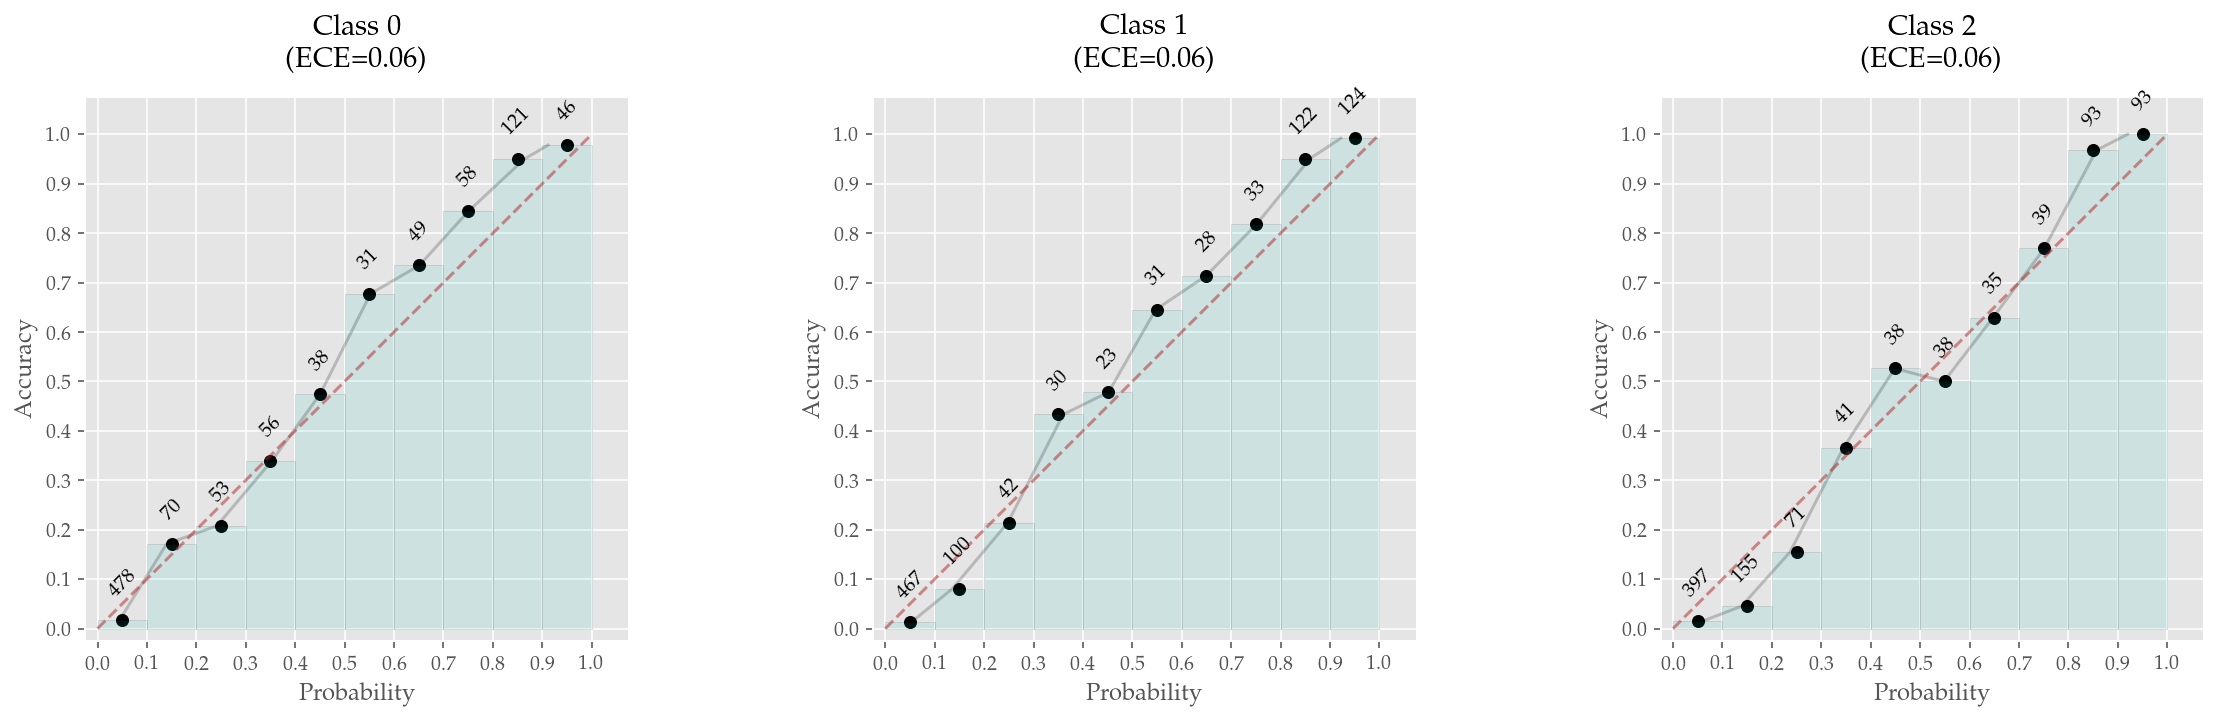

In [27]:
platt = cal.PlattCalibration()
plot_calibration_grid(probs_train, classes_train, platt, classes_val)

# Beta

Original Training - Accuracy = 0.81


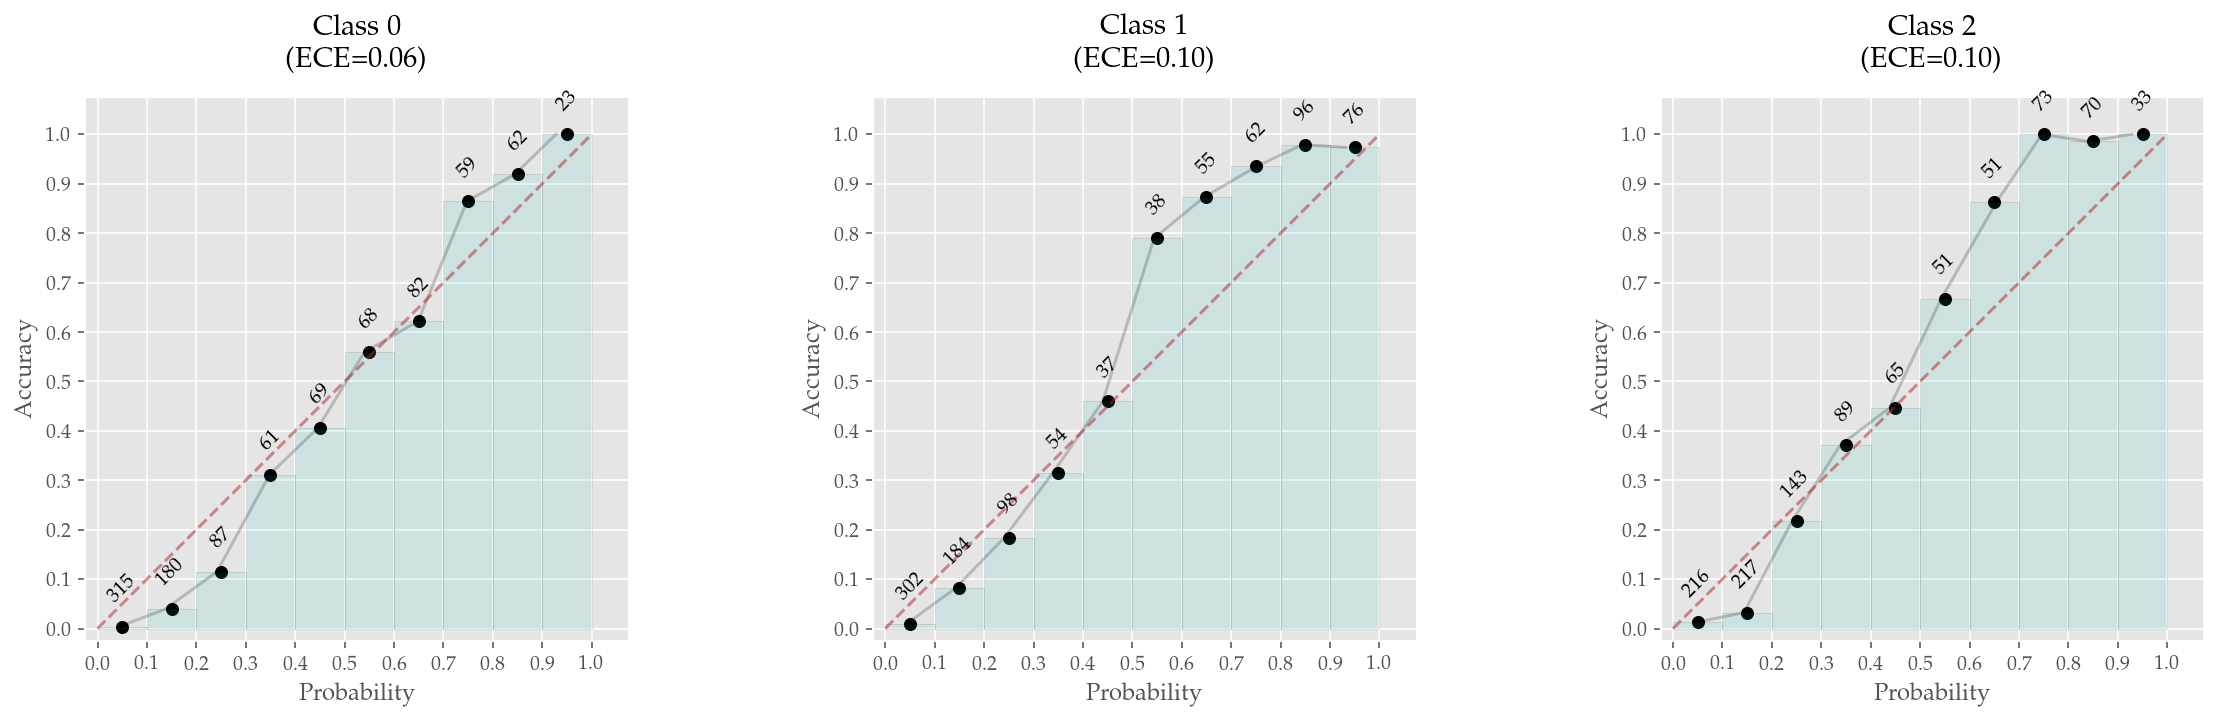

Calibrated Training (unormalized)


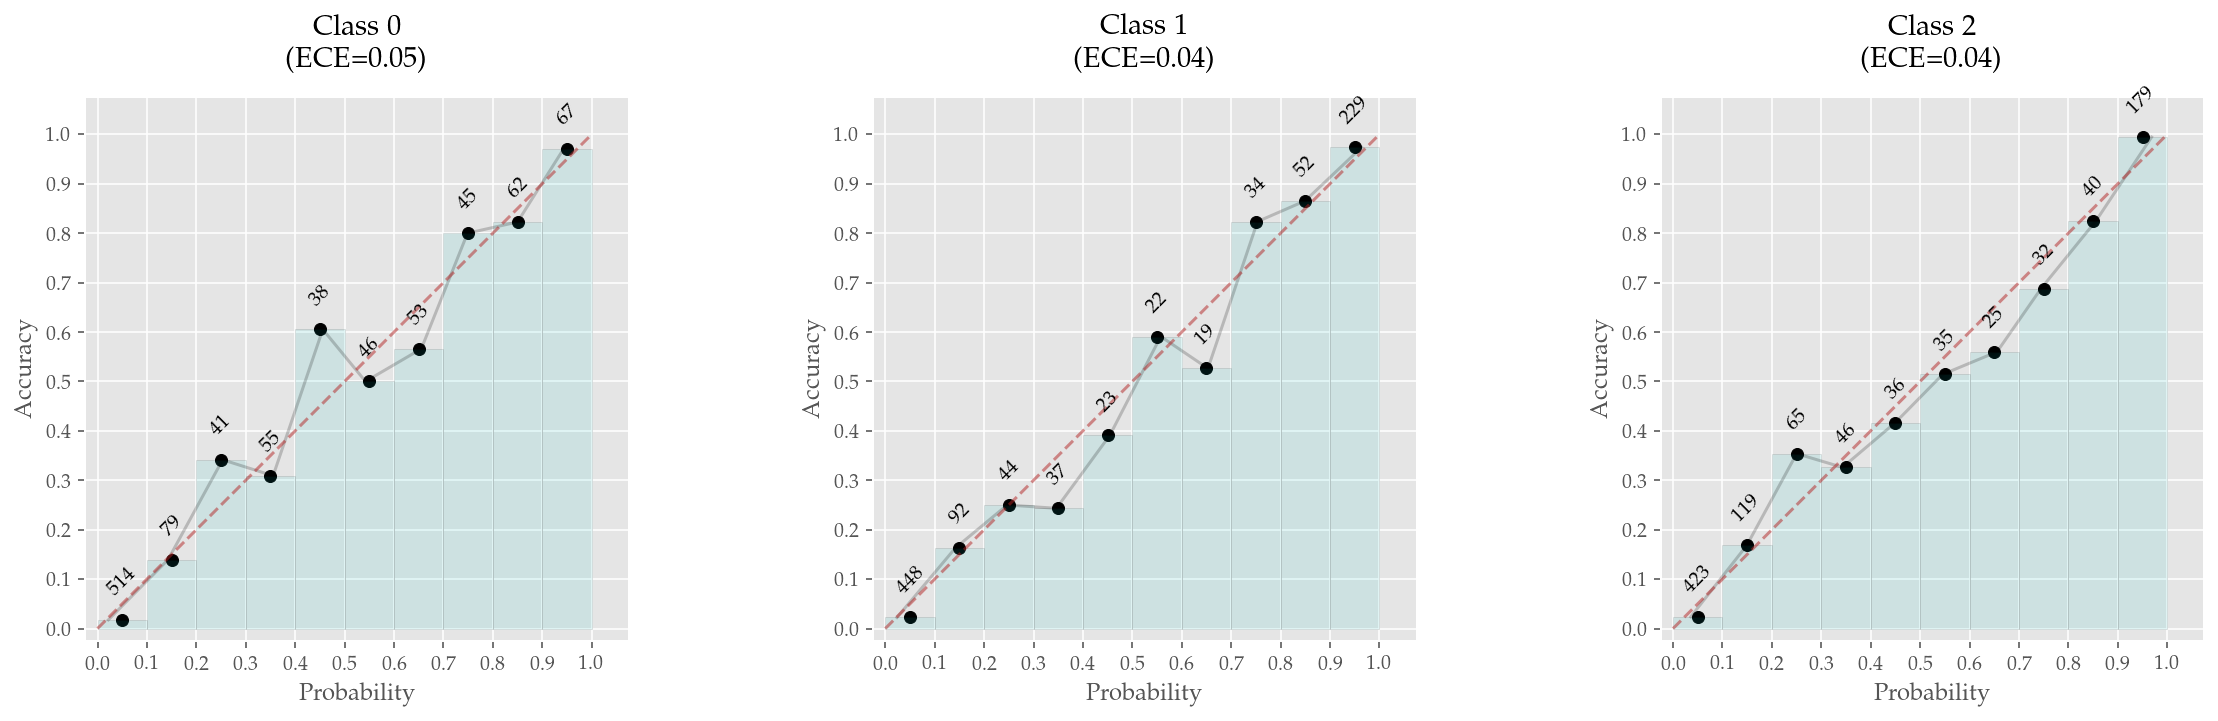

Calibrated Training (normalized) - Accuracy = 0.82


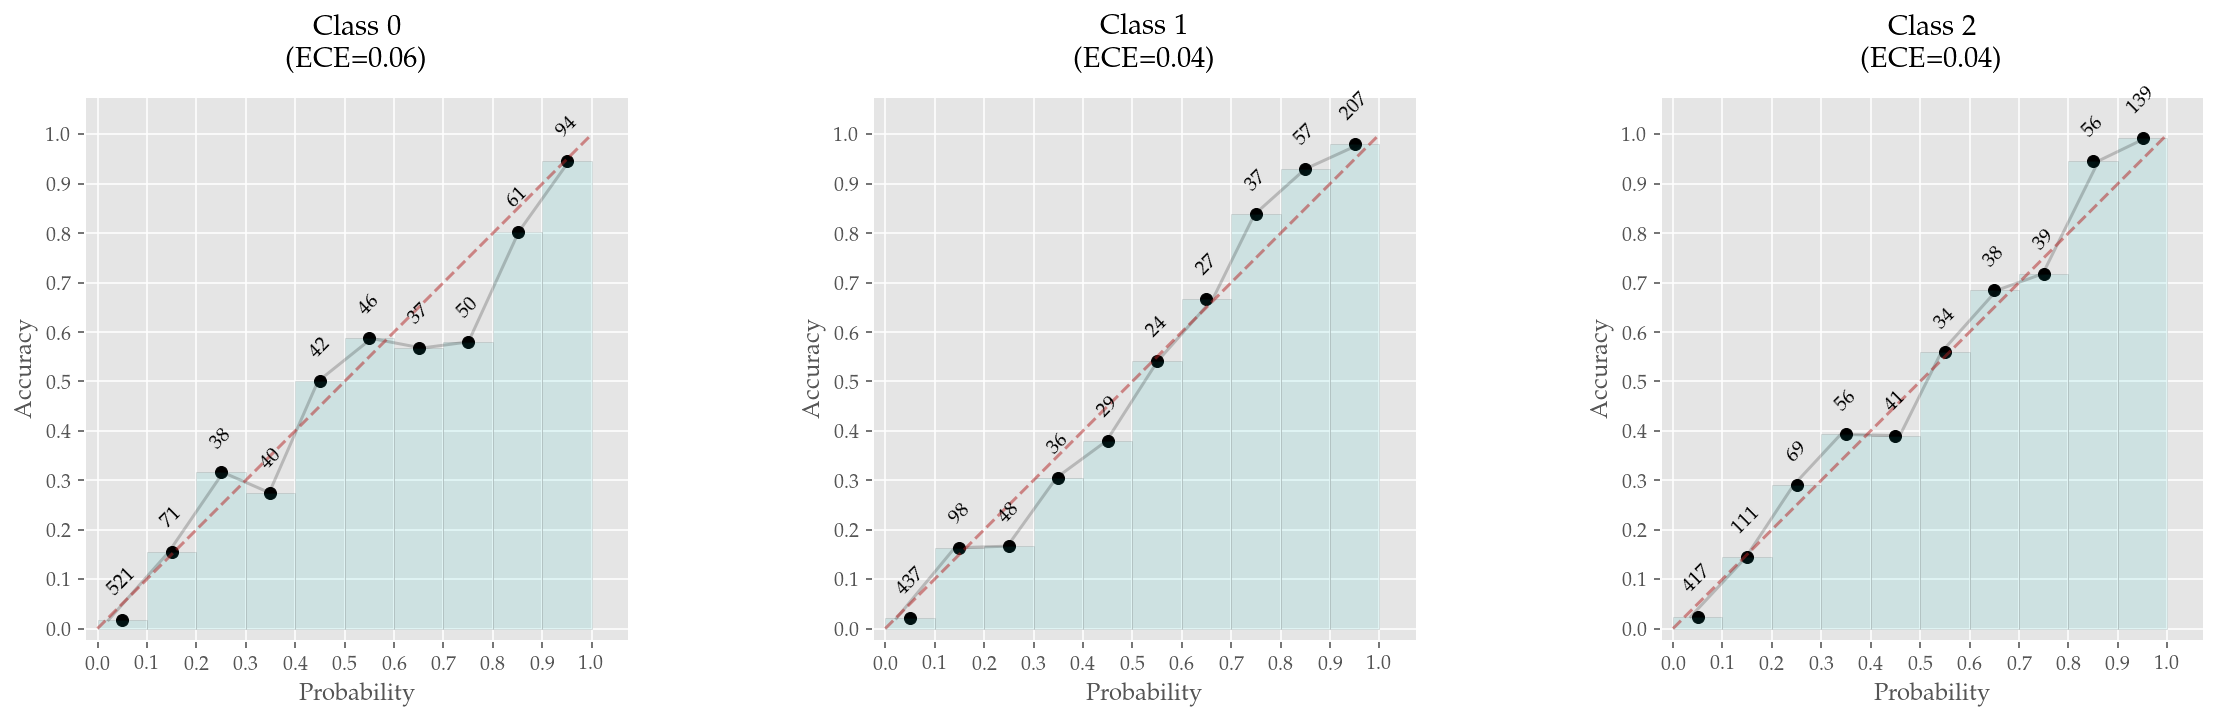

Original Val - Accuracy = 0.85


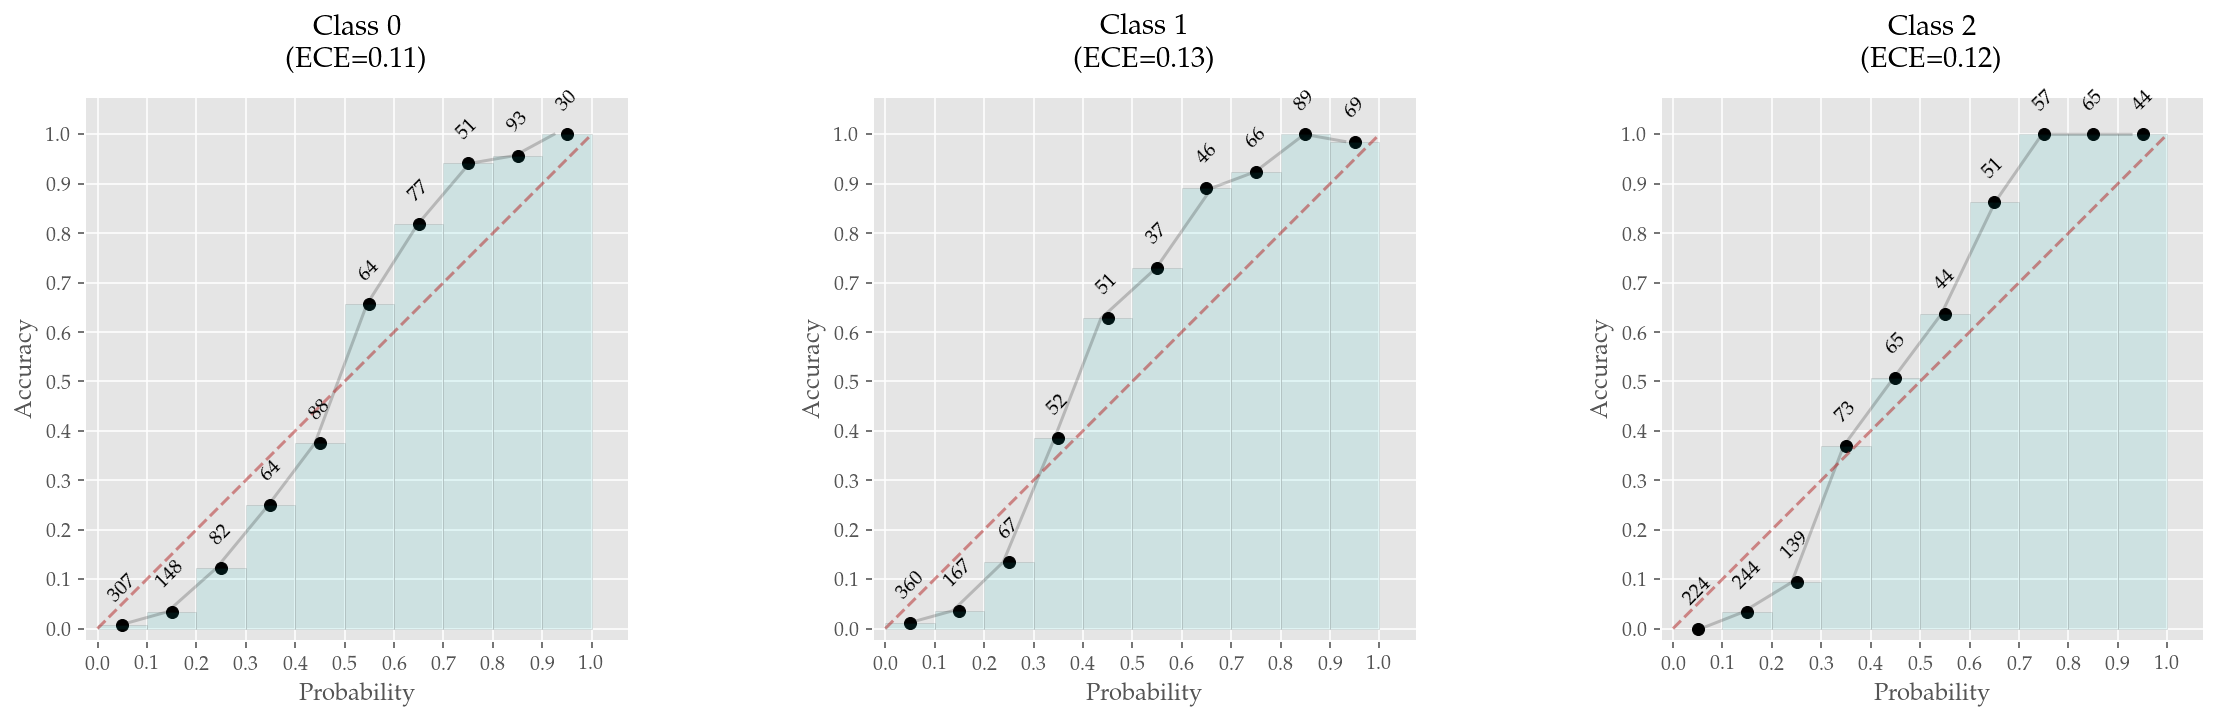

Calibrated Val (unormalized)


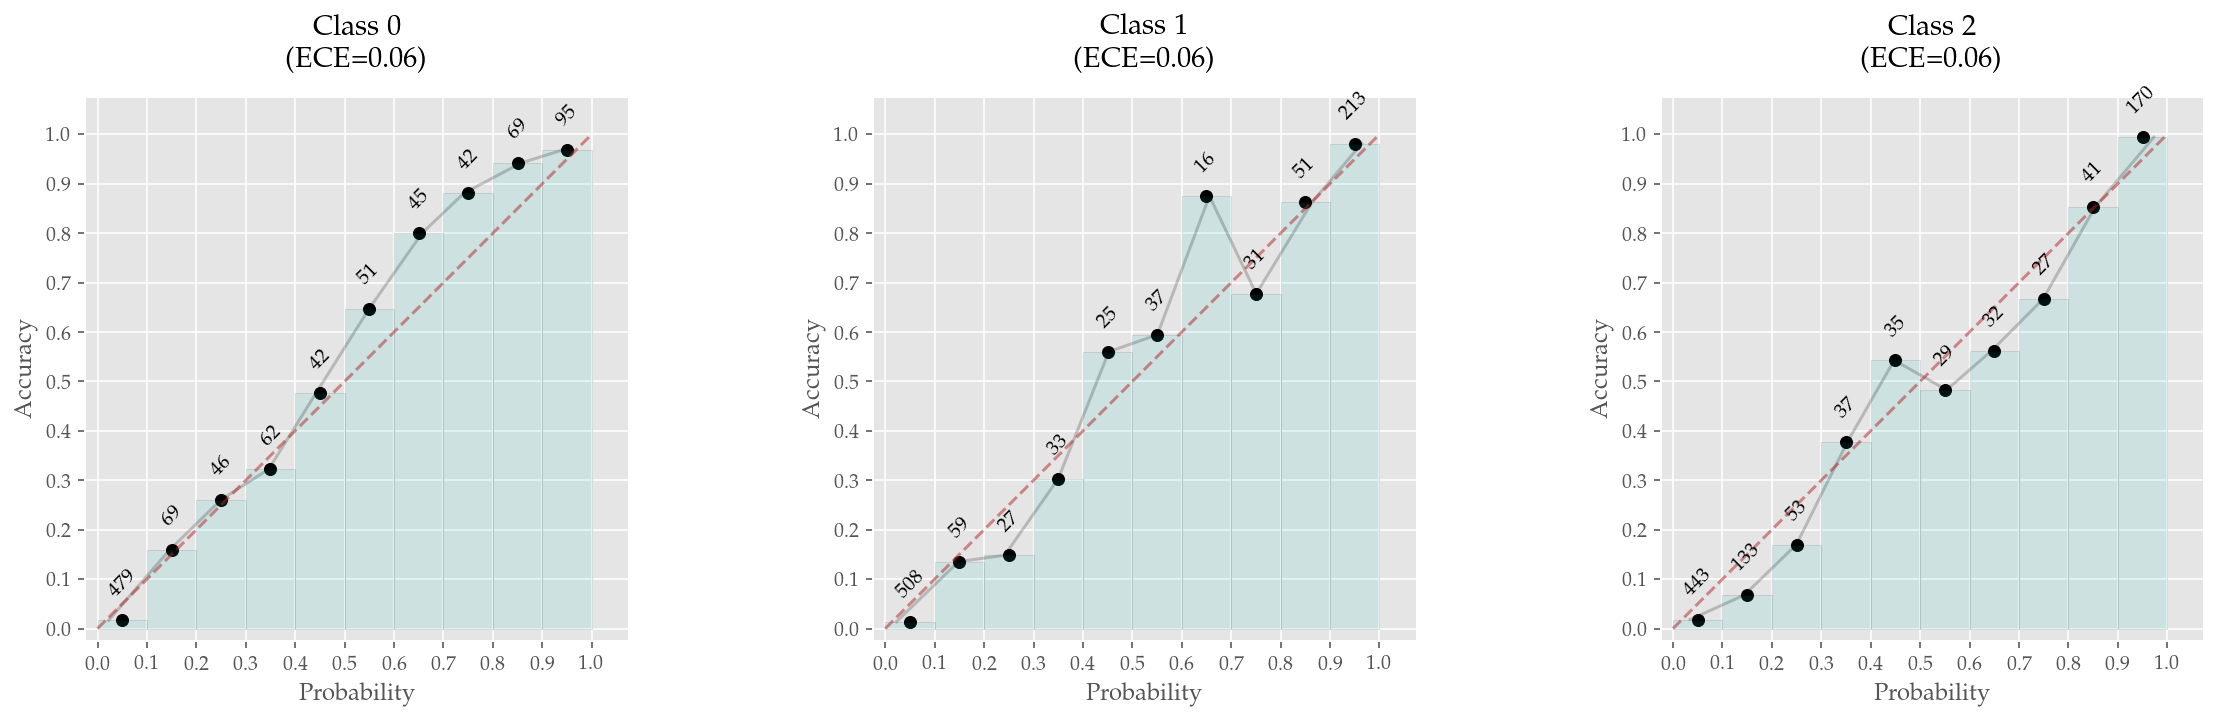

Calibrated Val (normalized) - Accuracy = 0.85


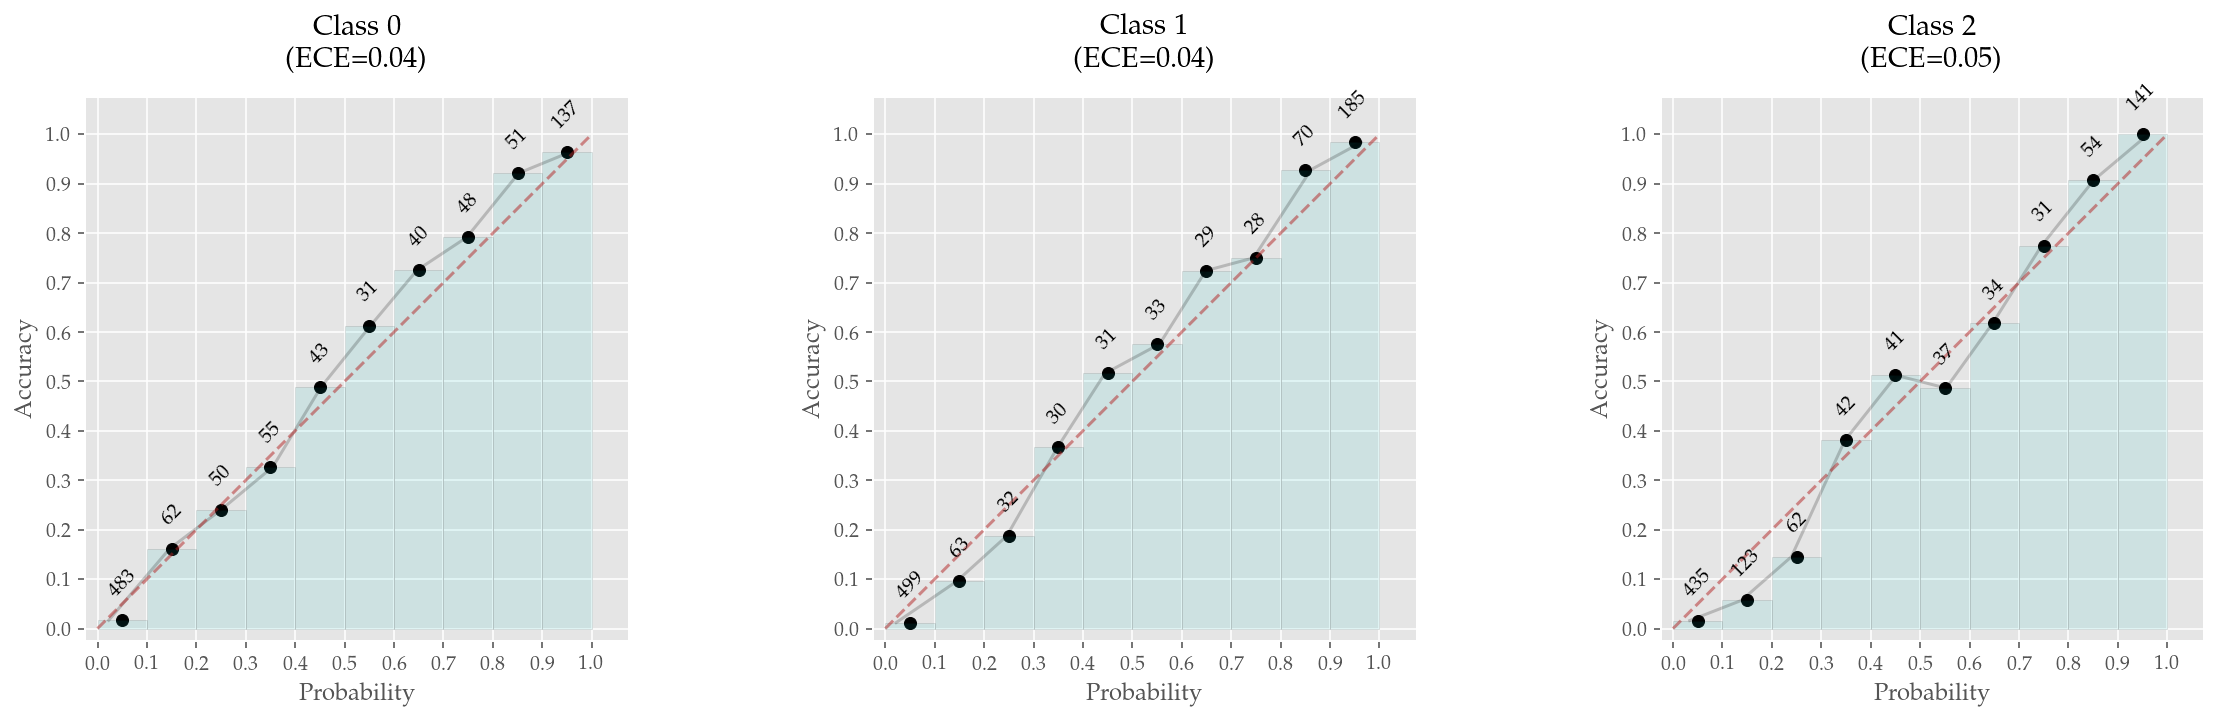

In [28]:
beta = cal.BetaCalibration()
plot_calibration_grid(probs_train, classes_train, beta, classes_val)

# Temperature Scaling

Original Training - Accuracy = 0.81


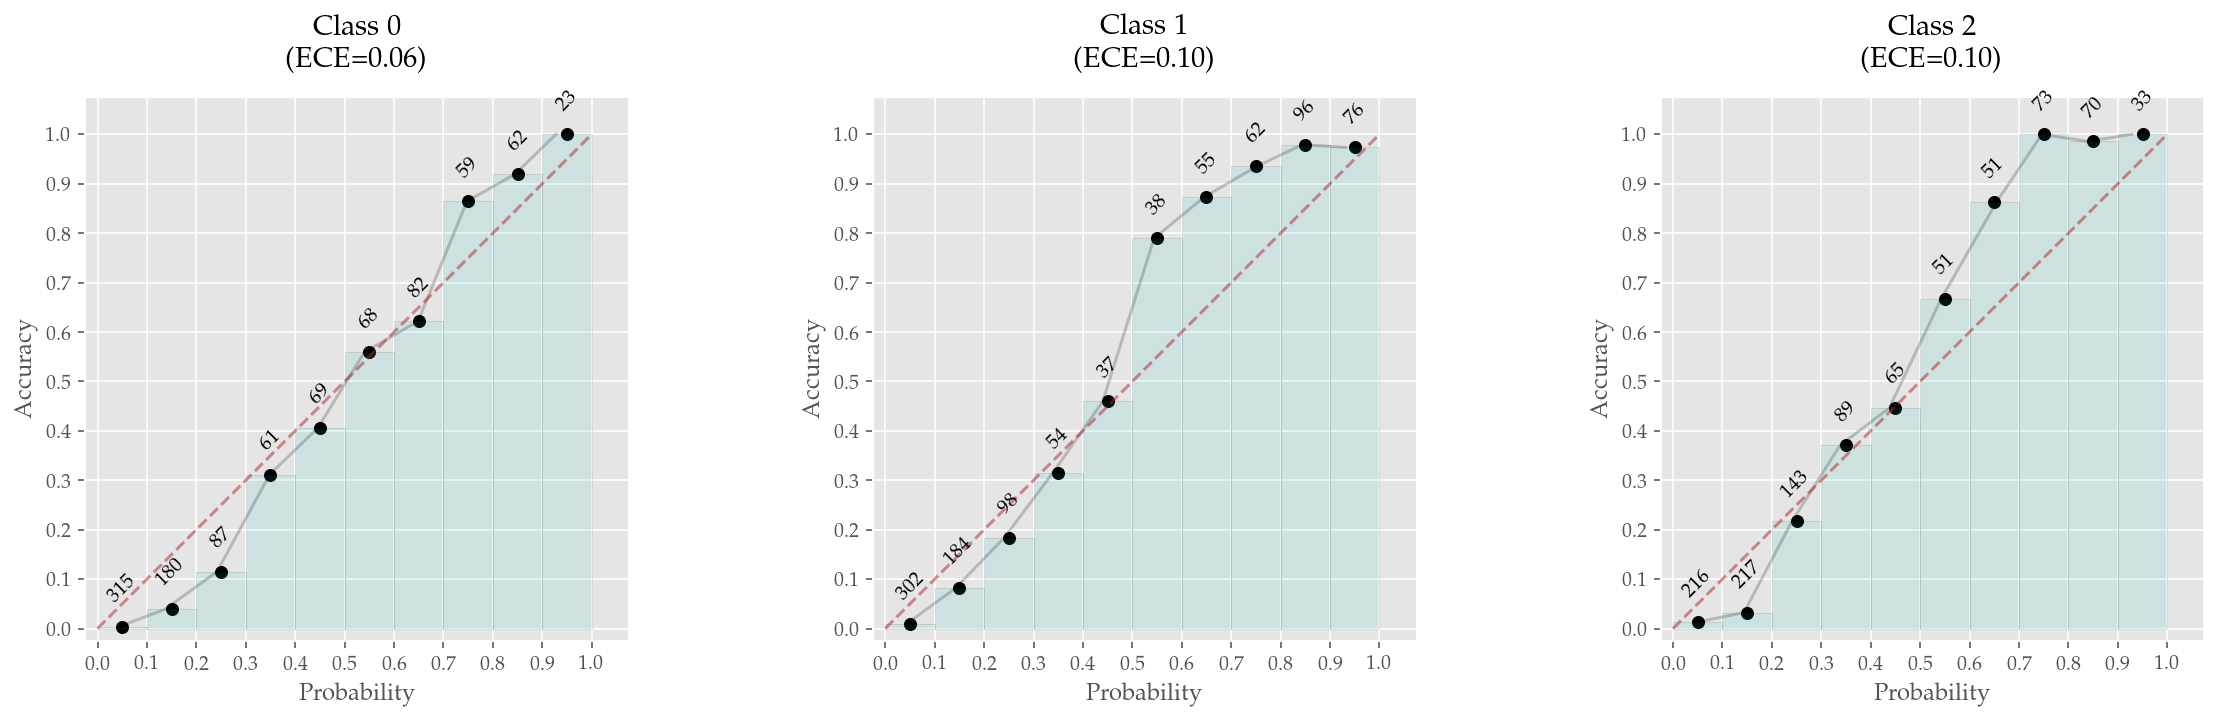

Calibrated Training (unormalized)


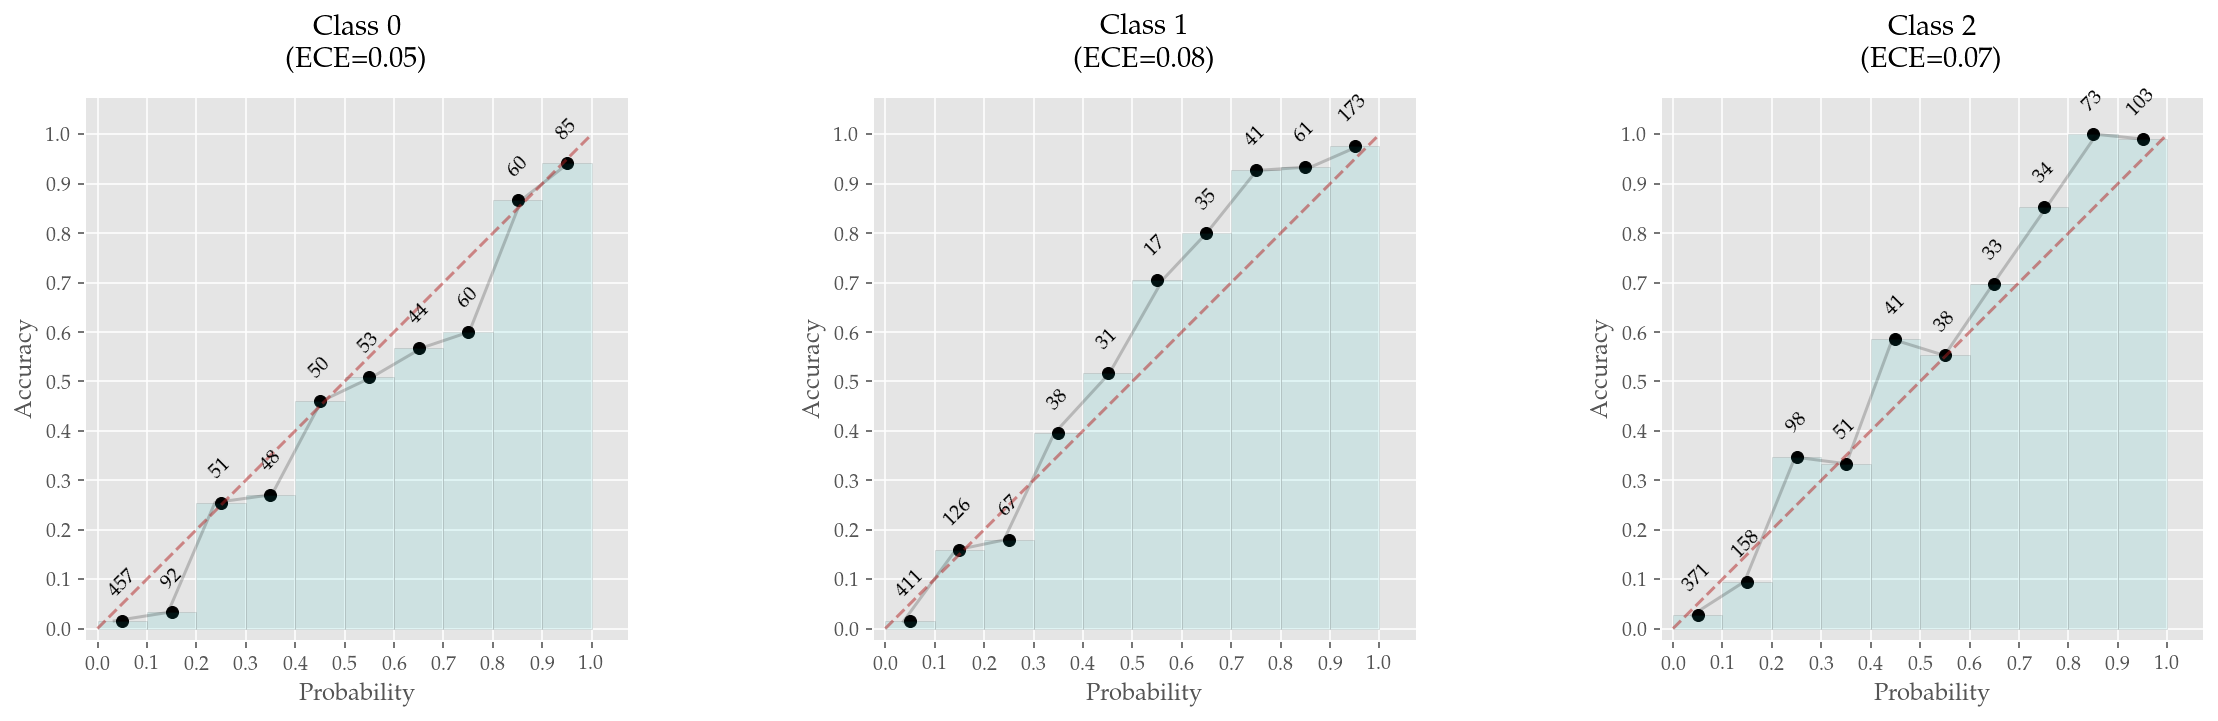

Calibrated Training (normalized) - Accuracy = 0.81


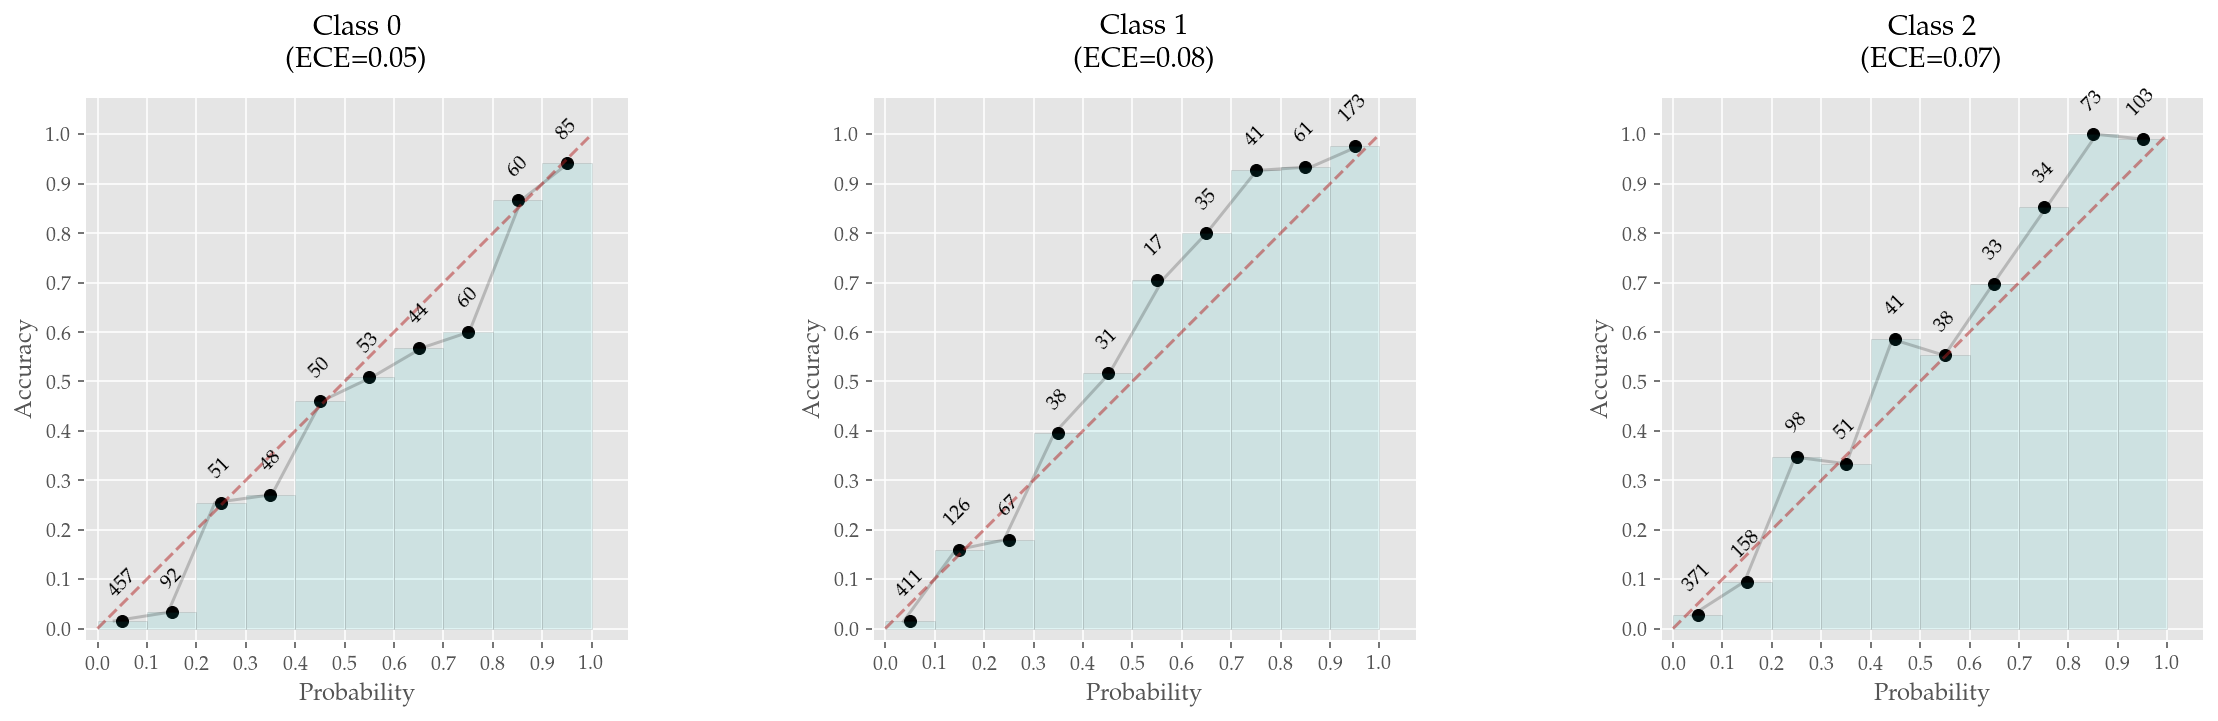

Original Val - Accuracy = 0.85


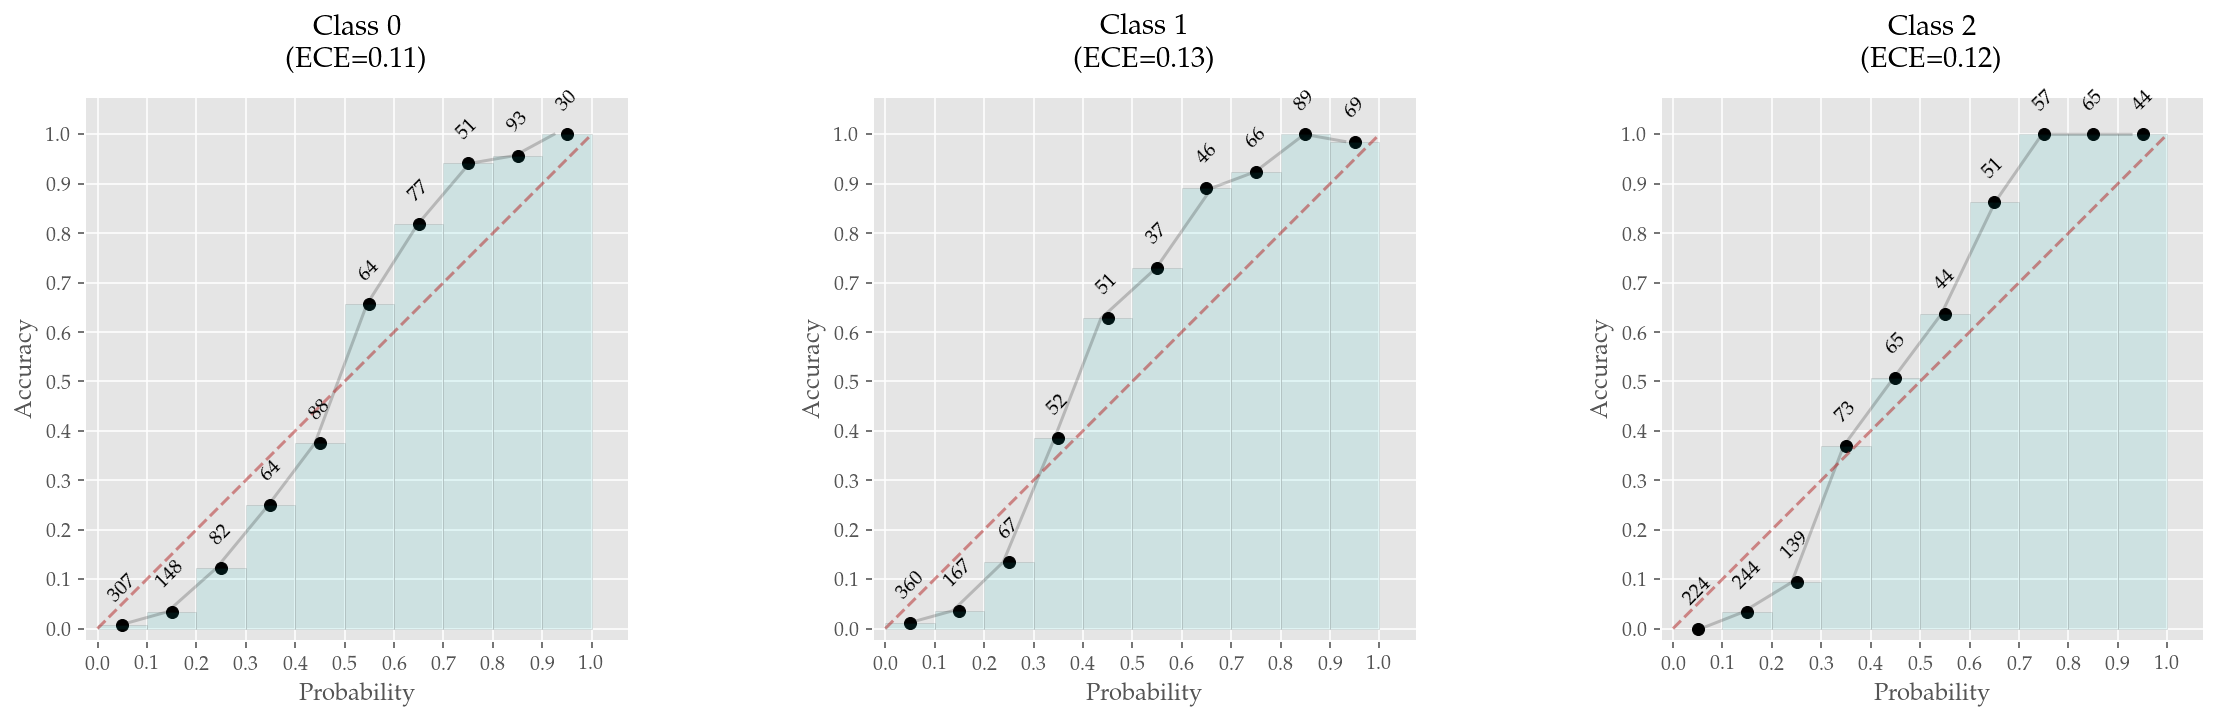

Calibrated Val (unormalized)


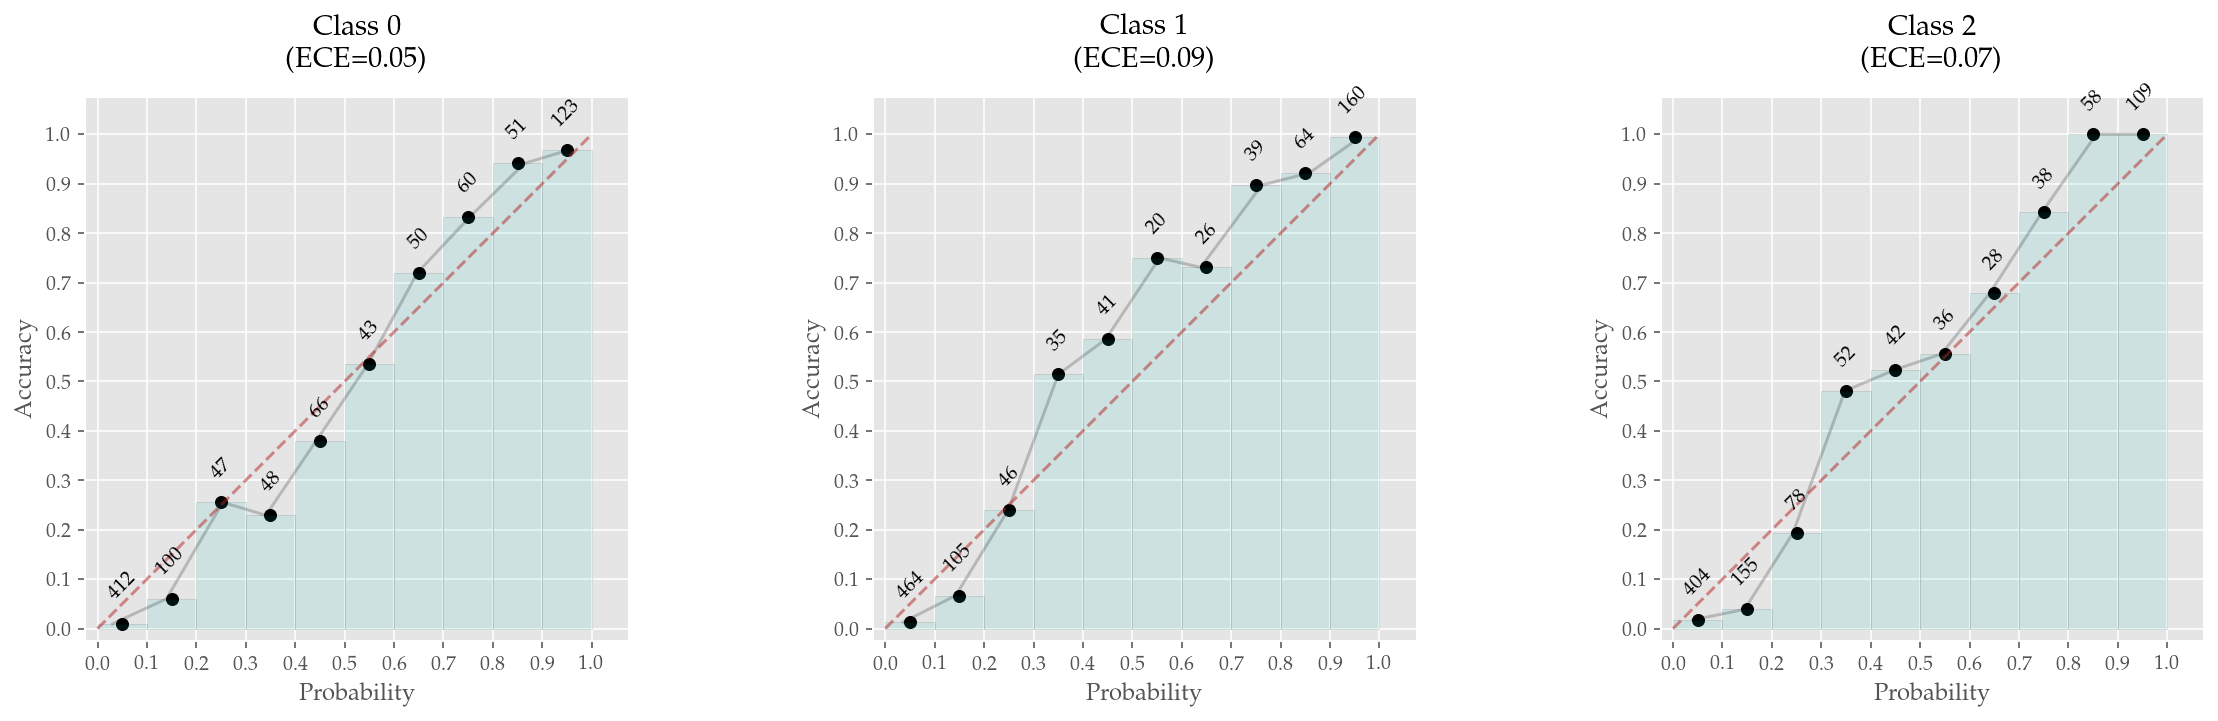

Calibrated Val (normalized) - Accuracy = 0.85


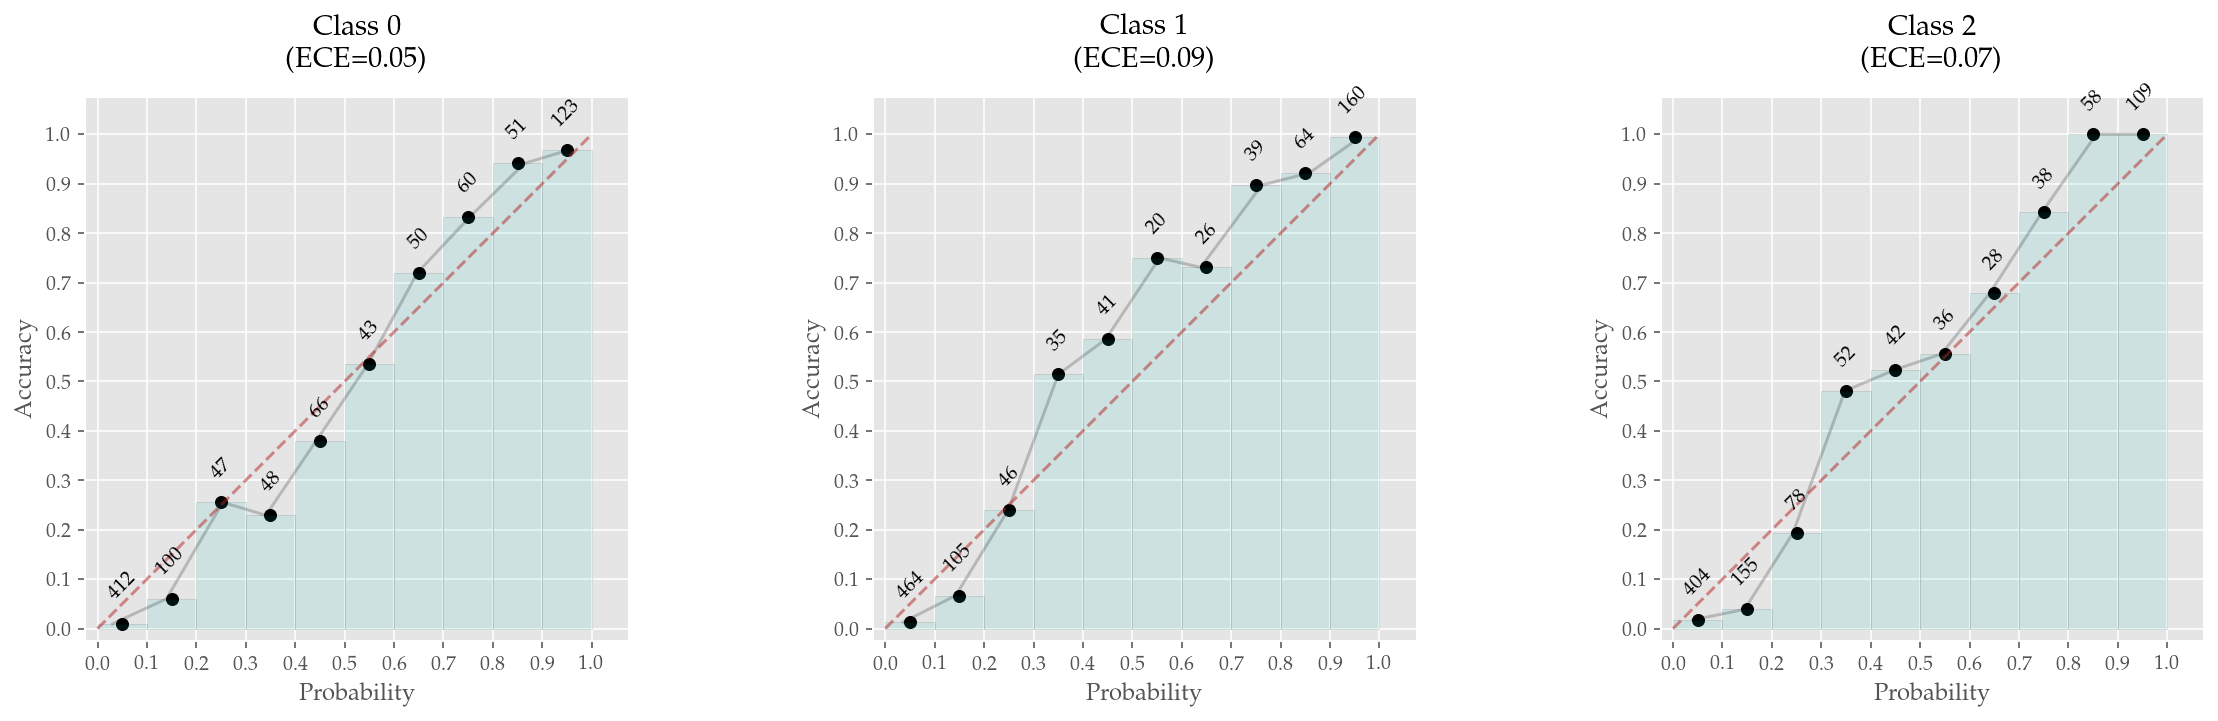

In [33]:
temperature_scaling = cal.TemperatureScaling(1.2)
plot_calibration_grid(probs_train, classes_train, temperature_scaling, classes_val)

# Unconstrained Linear Regression

Original Training - Accuracy = 0.81


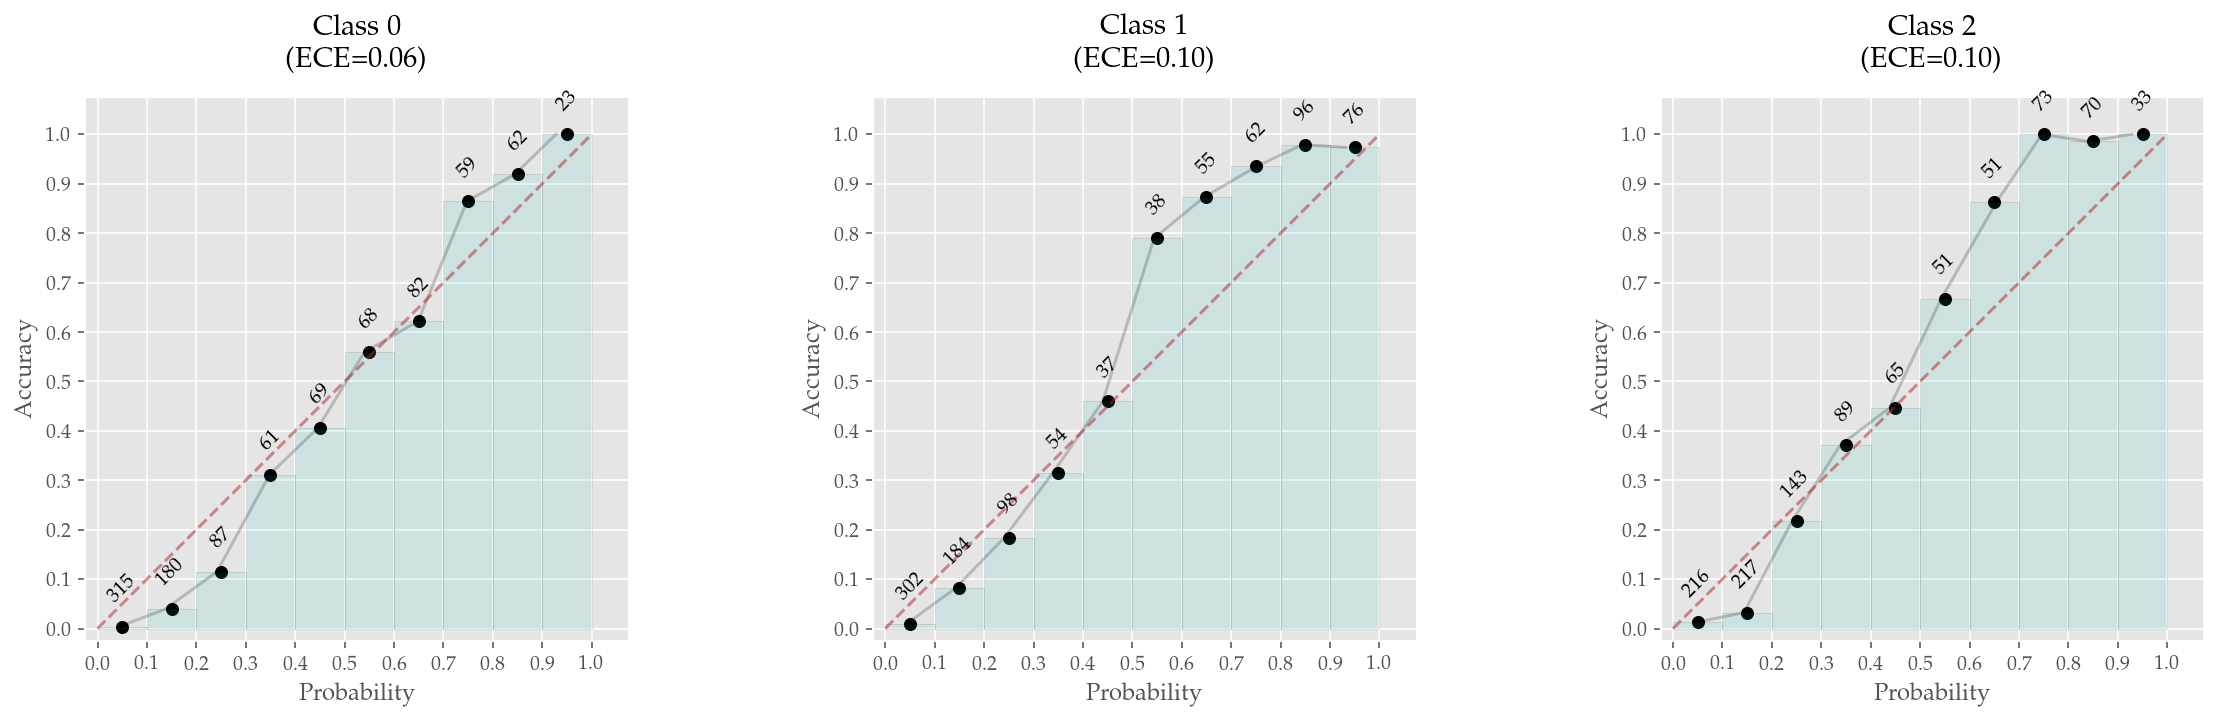

Calibrated Training (unormalized)


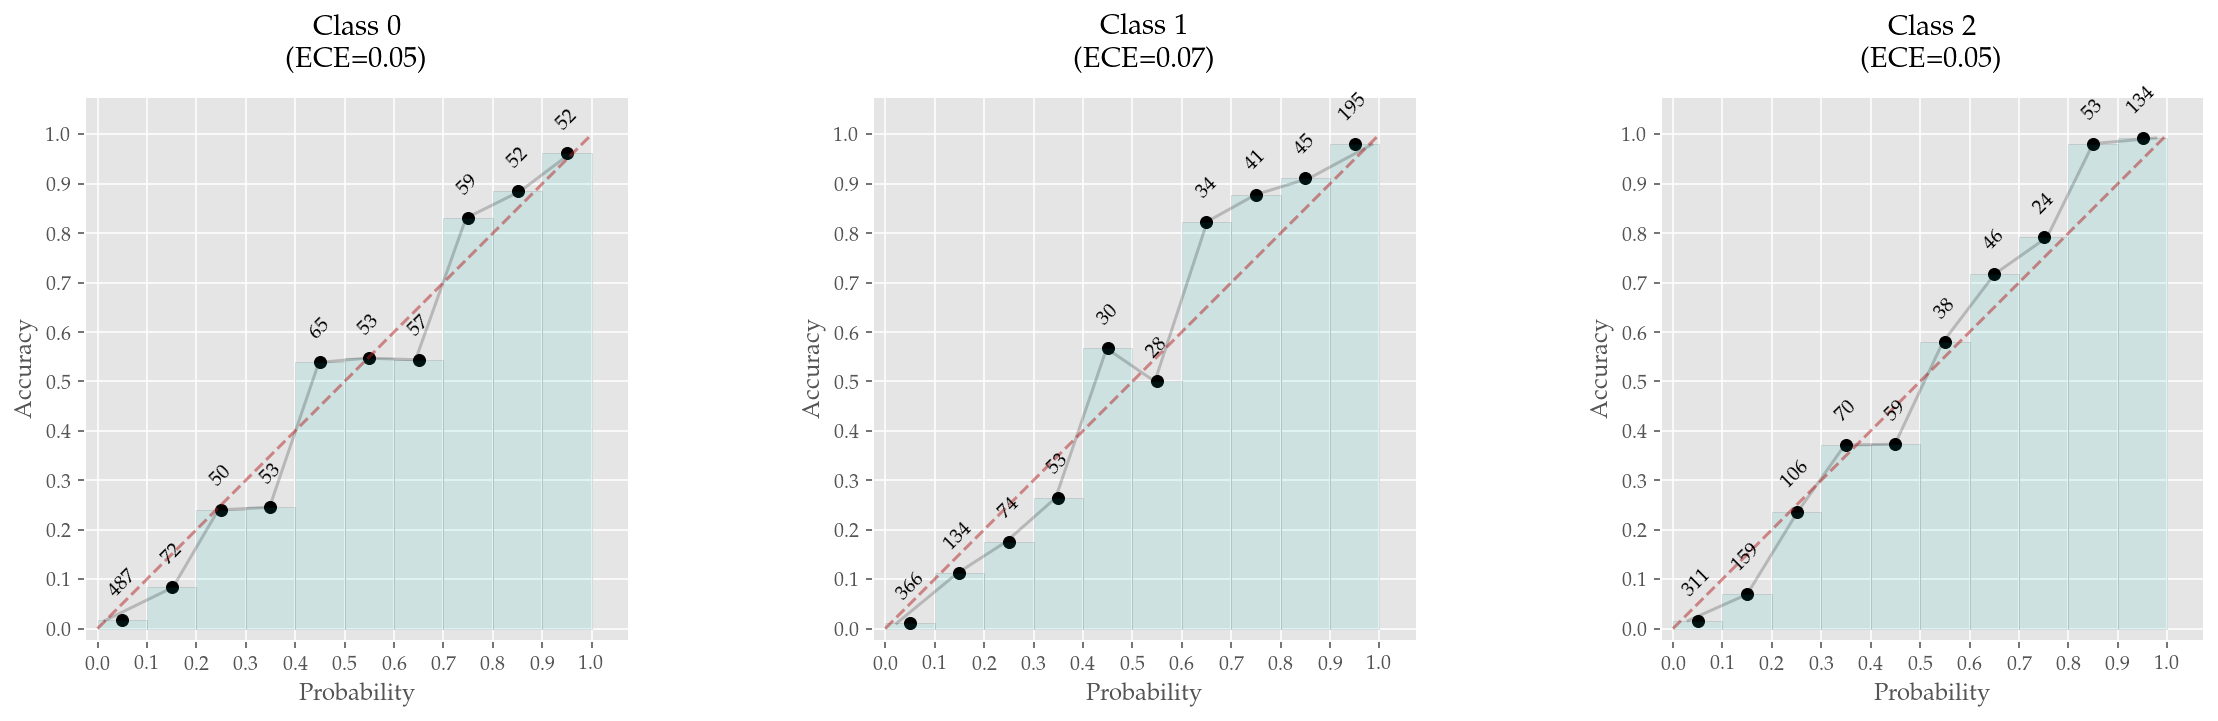

Calibrated Training (normalized) - Accuracy = 0.82


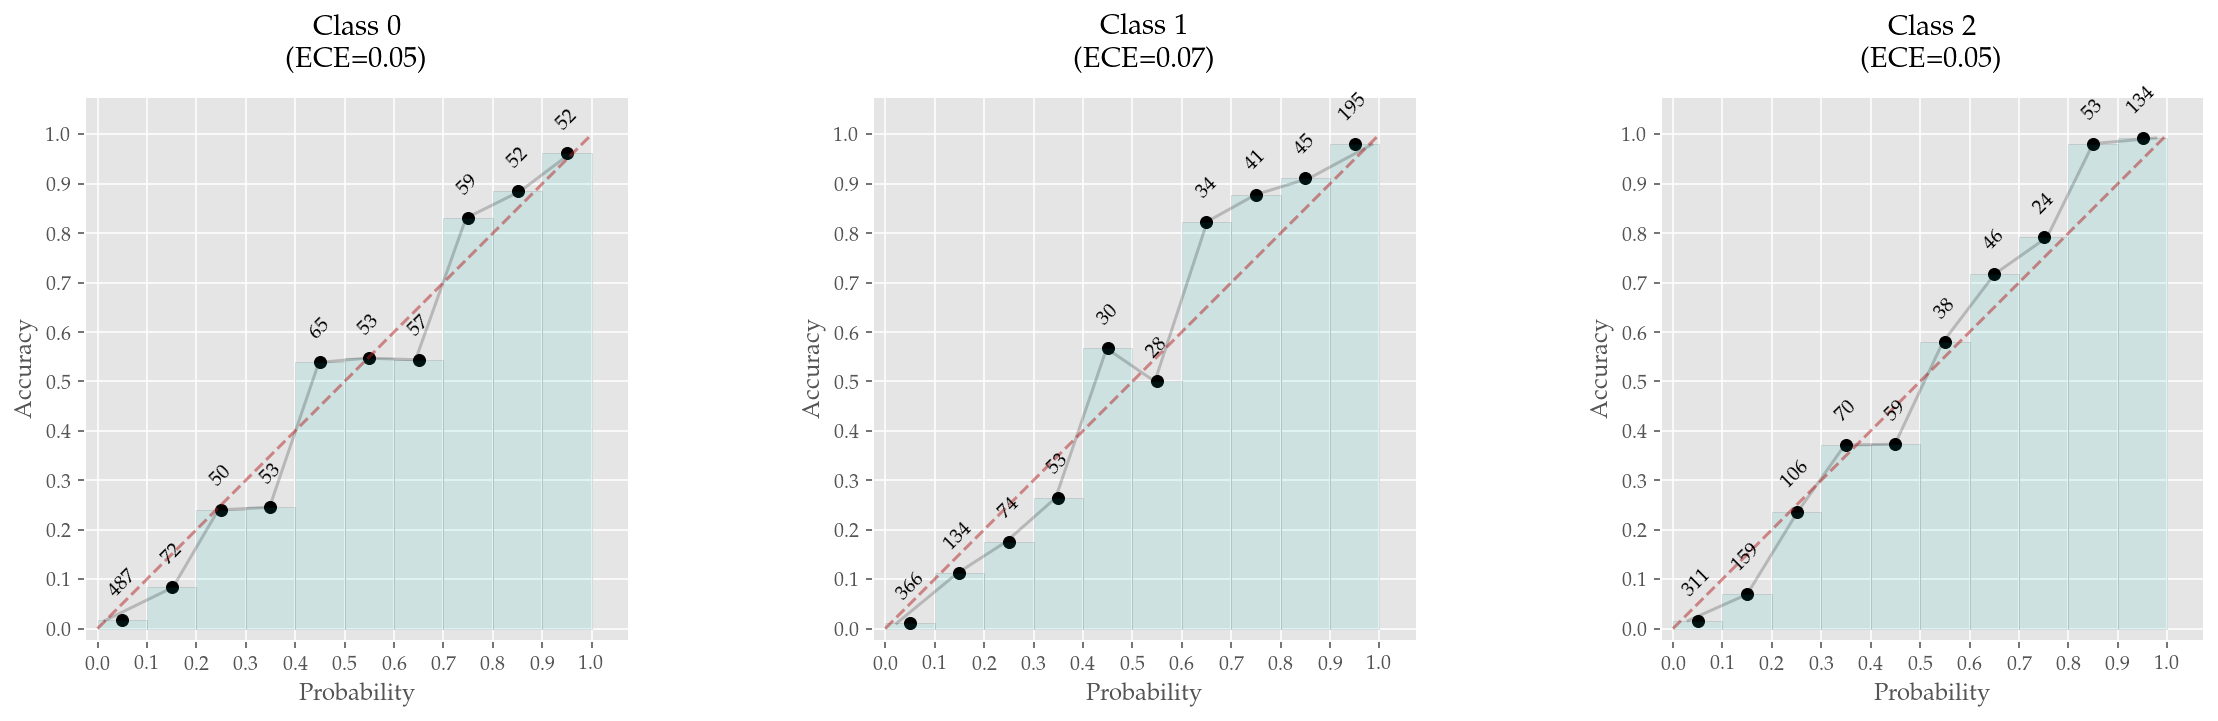

Original Val - Accuracy = 0.85


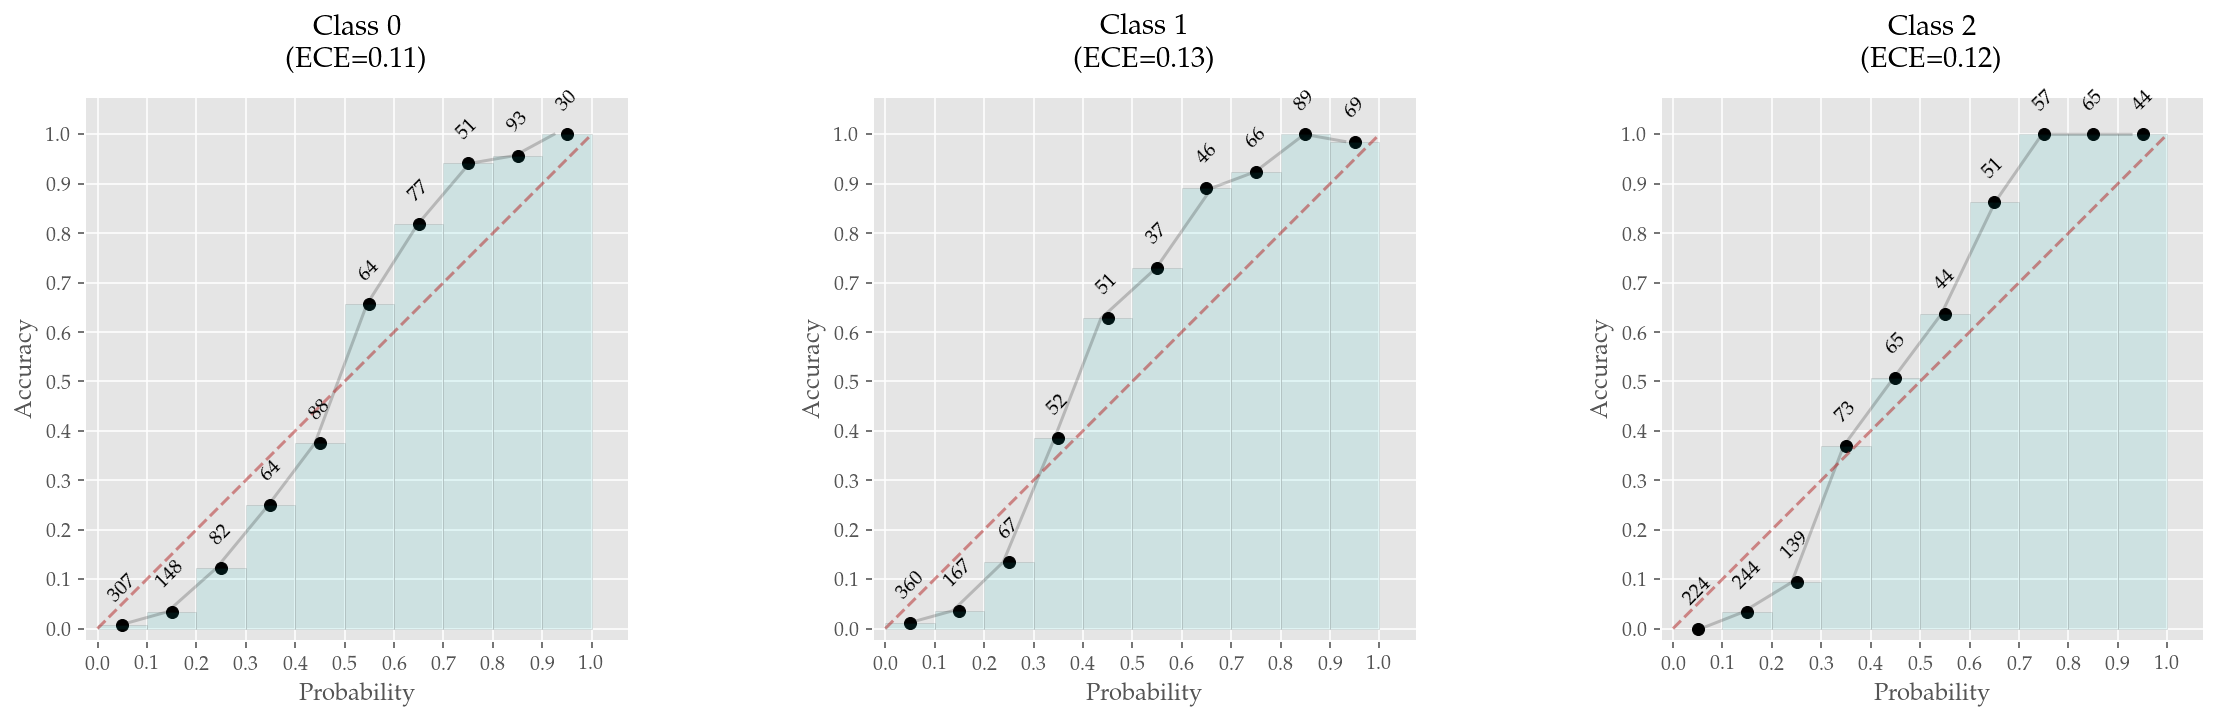

Calibrated Val (unormalized)


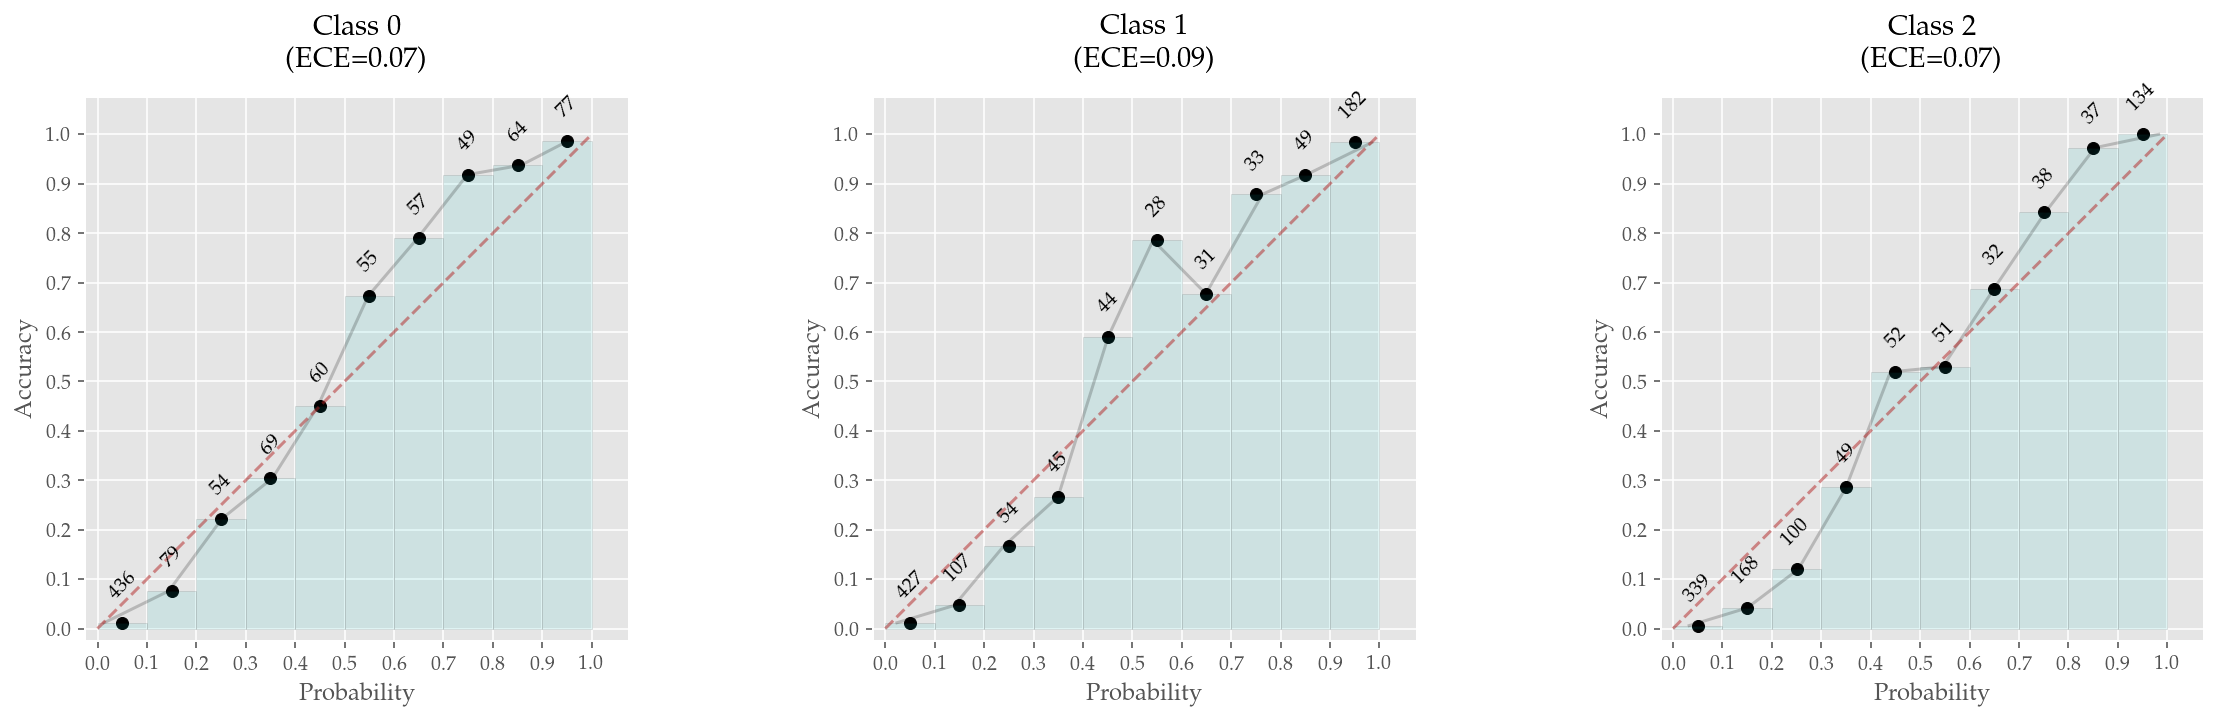

Calibrated Val (normalized) - Accuracy = 0.85


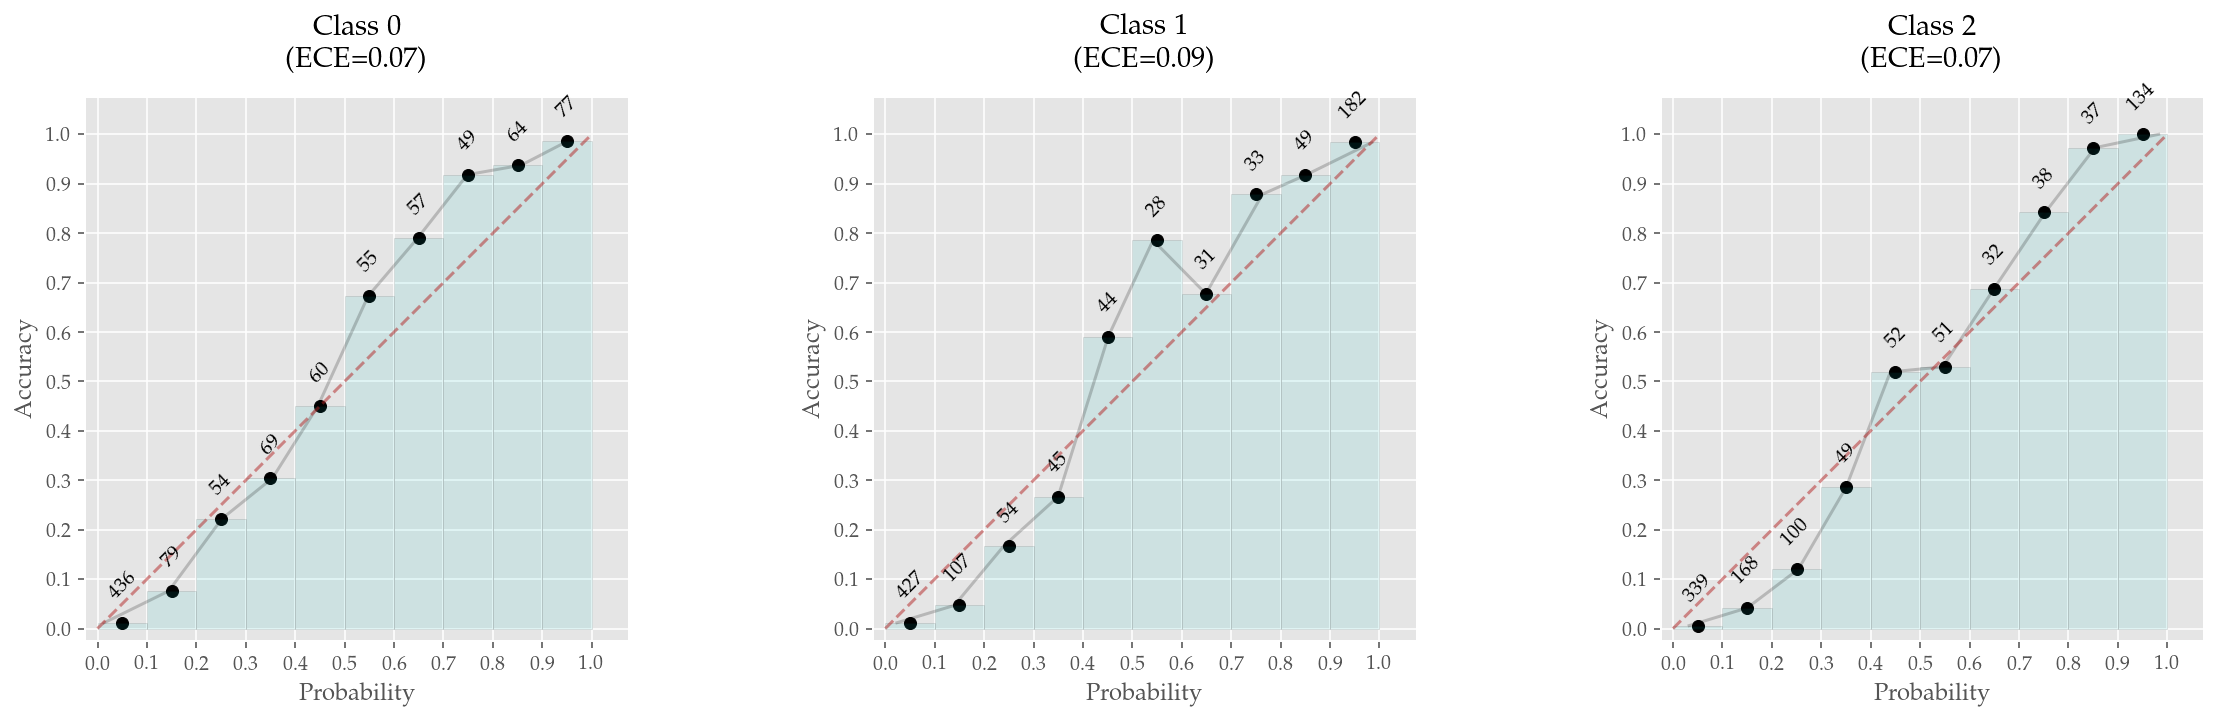

In [34]:
lr = cal.LinearRegressionCalibration(rel.GaussianKernel(), 10, False, True)
plot_calibration_grid(probs_train, classes_train, lr, classes_val)